In [20]:
import gc
import os
import sys
import time
import math
import torch.nn as nn

import pandas as pd
import torch
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from collections import defaultdict
from itertools import product


warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [21]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/val.csv")

In [22]:

# Compile the regular expression pattern
pattern = re.compile(r"[^a-z ]")


def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z.
    sentence = re.sub(pattern, " ", sentence)

    return sentence

sentence1 = "A World War II-era bomber flying out of formation"
text_preparetion(sentence1)

'a world war ii era bomber flying out of formation'

In [23]:
train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preparetion)
validation_df['preprocessed_text'] = validation_df['caption'].progress_apply(text_preparetion)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preparetion)

100%|██████████| 2000/2000 [00:00<00:00, 490992.57it/s]


In [24]:
train_df

id  \
0     417812c5-0ce4-499d-b97d-4d28827239bc   
1     5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36   
2     d2705b90-8347-4cab-a7a6-654540d9a489   
3     a3b33fe7-3085-4433-9c18-8814803891b4   
4     1514b0e4-0665-45bc-ab32-52fce326cc29   
...                                    ...   
9995  1d1df243-485d-4b29-82c8-7e34c0de1f5c   
9996  f7dfa883-e524-4974-b5ba-6b3c3db49087   
9997  602e83dc-6539-4c1a-8d19-c1481b5c24bf   
9998  d9ce2e8c-0831-466a-8756-4c40d772b1ce   
9999  b22cdca0-79b3-4b37-a173-5176a32096f6   

                                                caption  image_id  label  \
0     Wet elephants shake water onto people bathing ...    394330      0   
1          Two men holding tennis racquets on the court    130849      0   
2     A bird on a tree limb with mountains in the ba...    514790      0   
3     A kitchen and dining room are featured along w...    182096      0   
4        A fruit stand has various fruits on the table.     68788      1   
...                                                 ...       ...    ...   
9995     Several people stand in a field flying a kite.    522702      0   
9996       A batter hitting a pitch at a baseball game.    441874      1   
9997  A person on white surfboard next to group in a...    166716      0   
9998  A baseball player getting ready to swing at th...    517601      0   
9999                    a black cat is laying in a sink    394115      1   

                                      preprocessed_text  
0     wet elephants shake water onto people bathing ...  
1          two men holding tennis racquets on the court  
2     a bird on a tree limb with mountains in the ba...  
3     a kitchen and dining room are featured along w...  
4        a fruit stand has various fruits on the table   
...                                                 ...  
9995     several people stand in a field flying a kite   
9996       a batter hitting a pitch at a baseball game   
9997  a person on white surfboard next to group in a...  
9998  a baseball player getting ready to swing at th...  
9999                    a black cat is laying in a sink  

[10000 rows x 5 columns]

In [25]:


def build_simple_vocab(sentences, special_tokens=None):
    """
    Manually create a vocabulary from a list of tokenized sentences.
    
    Args:
        sentences (list of str): List of sentences to build vocabulary from.
        special_tokens (list of str): Special tokens like <pad>, <unk>.
        
    Returns:
        dict: A vocabulary mapping tokens to indices.
        dict: An inverse vocabulary mapping indices to tokens.
    """
    special_tokens = special_tokens or ['<pad>', '<unk>']
    vocab = defaultdict(lambda: len(vocab))  # Default index is the current vocab size
    for token in special_tokens:
        vocab[token]  # Add special tokens first
    
    # Add tokens from sentences
    for sentence in sentences:
        for token in sentence.split():
            if token.strip():  # Exclude empty tokens
                vocab[token]
    
    # Convert to a normal dict (no longer dynamic)
    vocab = dict(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab, inverse_vocab


# Vectorize a sentence
def vectorize_sentence(sentence, vocab):
    """
    Converts a sentence into a tensor of token indices using a given vocabulary,
    ignoring empty tokens.
    
    Args:
        sentence (str): Input sentence.
        vocab (Vocab): Vocabulary to map tokens to indices.
        
    Returns:
        torch.Tensor: Vectorized sentence as a tensor.
    """
    # Ensure '<unk>' exists in the vocabulary
    unk_idx = vocab.get('<unk>', -1)
    if unk_idx == -1:
        raise ValueError("The vocabulary must include '<unk>' for unknown tokens.")

    # Split sentence into tokens and map them to indices
    tokens = [token for token in sentence.split() if token.strip()]
    return torch.tensor([vocab.get(token, unk_idx) for token in tokens], dtype=torch.long)


# Custom Dataset Class
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, vocab, images_path, train=True, max_len=None):
        """
        Dataset for preprocessing image-text pairs.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vocab (Vocab): Vocabulary for text vectorization.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences. If None, no truncation.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vocab = vocab
        self.train = train
        self.max_len = max_len
        self.images_path = images_path

        # Define image transformations
        self.image_transform = transforms.Compose([
            transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process sentence
        sentence = row['caption']
        vectorized_sentence = vectorize_sentence(sentence, self.vocab)

        # Pad or truncate the sentence
        if len(vectorized_sentence) < self.max_len:
            padding_length = self.max_len - len(vectorized_sentence)
            pad_tensor = torch.full((padding_length,), self.vocab['<pad>'], dtype=torch.long)
            vectorized_sentence = torch.cat((vectorized_sentence, pad_tensor), dim=0)
        else:
            vectorized_sentence = vectorized_sentence[:self.max_len]

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
            
        try:
            image = Image.open(image_path).convert("RGB")  # Convert to RGB
            image = self.image_transform(image)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Handle labels (for training)
        if self.train:
            label = row['label']
            label = torch.tensor(label, dtype=torch.long)
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': label
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
                'id': row['id']
            }

In [26]:
tokenized_sentence = [sentence.split(" ") for sentence in train_df['preprocessed_text']]
max_len = max(len([token for token in sentence.split(" ")]) for sentence in train_df['preprocessed_text'])
print(max_len)
vocab, inverse_vocab = build_simple_vocab(train_df['preprocessed_text'])

53


In [27]:
train_dataset = PreprocessingDataset(train_df, vocab, train=True, max_len=max_len, images_path = "./dataset/train_images/")
test_dataset = PreprocessingDataset(test_df, vocab, train=False, max_len=max_len, images_path = "./dataset/test_images/")
val_dataset = PreprocessingDataset(validation_df, vocab, train=True, max_len=max_len, images_path = "./dataset/val_images/")

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True )
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
class CNN(nn.Module):
    def __init__(self, cnn_dropout_value):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(cnn_dropout_value),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(cnn_dropout_value),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(cnn_dropout_value),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()

    def forward(self, images):
        img_features = self.layers(images)  # (Batch, 128, 1, 1)
        img_features = self.flatten(img_features)  # (Batch, 128)
        return img_features


In [31]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, embedding_dim) for positional encodings
        position = torch.arange(0, max_len).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(float(max_len)) / embedding_dim))
        
        pe = torch.zeros(max_len, embedding_dim)  # Shape: (max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)  # Sin for even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Cos for odd indices
        
        pe = pe.unsqueeze(0)  # Add batch dimension: (1, max_len, embedding_dim)
        self.register_buffer('pe', pe)  # Register as non-learnable buffer

    def forward(self, x):
        """
        Add positional encoding to the input embeddings.
        x: (Batch, SeqLen, EmbeddingDim)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

In [32]:
class TextModule(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, transformer_hidden_dim, num_transformer_layers, seq_len, transformer_dropout_value):
        super(TextModule, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab["<pad>"])
        self.positional_encoding = PositionalEncoding(embedding_dim=embedding_dim, max_len=seq_len)
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=num_heads,
                dim_feedforward=transformer_hidden_dim,
                dropout=transformer_dropout_value,
                activation='relu'
            ),
            num_layers=num_transformer_layers
        )

    def forward(self, captions):
        embedded_captions = self.embedding(captions)  # (Batch, SeqLen, EmbeddingDim)
        pos_encoded_captions = self.positional_encoding(embedded_captions)  # Apply positional encoding
        
        # Transformer expects input shape (SeqLen, Batch, EmbeddingDim)
        transformer_input = pos_encoded_captions.permute(1, 0, 2)  # (SeqLen, Batch, EmbeddingDim)
        transformer_output = self.transformer_encoder(transformer_input)  # (SeqLen, Batch, EmbeddingDim)
        text_features = transformer_output.mean(dim=0)  # Mean pooling over SeqLen: (Batch, EmbeddingDim)
        return text_features

In [33]:
class Head(nn.Module):
    def __init__(self, image_feature_dim, text_feature_dim, transformer_dropout_value, num_classes):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(image_feature_dim + text_feature_dim, 256)  # Combine image + text features
        self.dropout = nn.Dropout(transformer_dropout_value)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, img_features, text_features):
        combined_features = torch.cat((img_features, text_features), dim=1)  # (Batch, 128 + EmbeddingDim)
        x = F.relu(self.fc1(combined_features))  # (Batch, 256)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # (Batch, num_classes)
        return x.squeeze(1)  # Logits (not probabilities)

In [34]:
class ImageTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, transformer_hidden_dim, num_transformer_layers, seq_len, cnn_dropout_value, transformer_dropout_value, num_classes=1):
        super(ImageTextClassifier, self).__init__()
        self.cnn = CNN(cnn_dropout_value)
        self.text_module = TextModule(
            vocab_size, embedding_dim, num_heads,
            transformer_hidden_dim, num_transformer_layers,
            seq_len, transformer_dropout_value
        )
        self.head = Head(image_feature_dim=128, text_feature_dim=embedding_dim, transformer_dropout_value=transformer_dropout_value, num_classes=num_classes)

    def forward(self, images, captions):
        img_features = self.cnn(images)  # Image feature extraction
        text_features = self.text_module(captions)  # Text feature extraction
        return self.head(img_features, text_features)  # Classification

In [35]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.TransformerEncoderLayer):
        for name, param in m.named_parameters():
            if "weight" in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.ones_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [36]:
# # Test model code
model = ImageTextClassifier(
    vocab_size=10000,  # Example parameters
    embedding_dim=128,
    num_heads=8,
    transformer_hidden_dim=512,
    num_transformer_layers=6,
    seq_len=max_len,
    cnn_dropout_value=0.3,
    transformer_dropout_value=0.3,
    num_classes=1
)

# Apply weight initialization recursively
model.apply(initialize_weights)

# Dummy input data
images = torch.randn(16, 3, 100, 100)  # Batch of 16 RGB images of size 224x224
captions = torch.randint(0, len(vocab), (16, max_len))  # Batch of 16 captions with max_len tokens each

output = model(images, captions)
print(output.shape)  # Should be (16) 

torch.Size([16])


In [37]:
# Initialize the model
model_config = {
    "vocab_size": len(vocab),
    "embedding_dim": 128,
    "num_heads": 2,
    "transformer_hidden_dim": 256,
    "num_transformer_layers": 2,
    "seq_len": max_len,
    "cnn_dropout_value": 0.4,
    "transformer_dropout_value": 0.5,
}
model = ImageTextClassifier(**model_config)
model.to(device)
model.apply(initialize_weights)

ImageTextClassifier(
  (cnn): CNN(
    (layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Dropout(p=0.4, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): Dropout(p=0.4, inplace=False)
      (14): AdaptiveAvgPool2d(output_size=(1, 1))
    )
    (flatten): Flatten(st

In [38]:
criterion = nn.BCEWithLogitsLoss()  # Use logits directly
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
 # T_0 -> Number of iterations until the first restart
 # T_mult -> Double the cycle length after every restart
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,  # Number of epochs before the first restart
    T_mult=2,  # Multiplicative factor for increasing restart period
    eta_min=1e-7  # Minimum learning rate
)

In [39]:
import copy

def training_method(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, patience=5, delta = 0.01, loss_procentage_improvement=10):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = [] # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_model = None  # Store the best model
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        ### TRAINING
        model.train()
        training_loss = 0.0
        
        for batch in train_loader:
            images = batch['images'].to(device)      # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float
            
            optimizer.zero_grad()  # Reset gradients
            output = model(images, captions)  # Forward pass (logits)
            loss = criterion(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            
            optimizer.step()  # Update weights
            training_loss += loss.item()  # Accumulate loss
            
        train_loss = training_loss / len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []   # Predictions for validation
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()
                
                output = model(images, captions)  # Forward pass (logits)
                loss = criterion(output, labels)  # Compute validation loss
                validation_loss += loss.item()
                
                # Convert logits to probabilities and apply threshold
                preds = (torch.sigmoid(output) > 0.5).float()
                
                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
        val_loss = validation_loss / len(val_loader)  # Average validation loss
        val_losses.append(val_loss)
        
        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Save the best model
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss - delta:
            print(f"Validation loss did not improve significantly")            
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop


        # Step the learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate
        learning_rates.append(current_lr)
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f} - "
              f"Lr: {current_lr:.2e}")

    print('Training finished!')
    
    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        plt_save_path = "models/"
        model_config['eval_loss'] = best_val_loss
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()
        
        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Progression")
        plt.legend()
    
        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()
    
    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")

In [40]:
# training_method(model, criterion, optimizer, scheduler, num_epochs=100, train_loader=train_dataloader, val_loader=val_dataloader)

In [41]:
ids = []
predictions = []

def make_submission(model, test_loader):
    model.eval()

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            id = batch['id']
            
            output = model(images, captions)
            preds = (torch.sigmoid(output) > 0.5).int()
            
            ids.extend(id)
            predictions.extend(preds.cpu().tolist())
    df = pd.DataFrame({'id': ids, 'label': predictions})
    df.to_csv('submission2.csv', index=False)

In [42]:
model_config = {
    "vocab_size": len(vocab),
    "embedding_dim": 128,
    "num_heads": 2,
    "transformer_hidden_dim": 256,
    "num_transformer_layers": 2,
    "seq_len": max_len,
    "cnn_dropout_value": 0.4,
    "transformer_dropout_value": 0.5,
}
model = ImageTextClassifier(**model_config)
model_path = "models/vocab_size=3733+embedding_dim=128+num_filters=128+filter_sizes=[3, 4, 5, 6, 7, 8]+seq_len=53+cnn_text_drop_value=0.5+cnn_dropout_value=0.4+transformer_dropout_value=0.5+num_classes=1+eval_loss=0.6212541232717798.pt"
model.load_state_dict(torch.load(model_path, weights_only=True))

RuntimeError: Error(s) in loading state_dict for ImageTextClassifier:
	Missing key(s) in state_dict: "text_module.transformer_encoder.layers.0.self_attn.in_proj_weight", "text_module.transformer_encoder.layers.0.self_attn.in_proj_bias", "text_module.transformer_encoder.layers.0.self_attn.out_proj.weight", "text_module.transformer_encoder.layers.0.self_attn.out_proj.bias", "text_module.transformer_encoder.layers.0.linear1.weight", "text_module.transformer_encoder.layers.0.linear1.bias", "text_module.transformer_encoder.layers.0.linear2.weight", "text_module.transformer_encoder.layers.0.linear2.bias", "text_module.transformer_encoder.layers.0.norm1.weight", "text_module.transformer_encoder.layers.0.norm1.bias", "text_module.transformer_encoder.layers.0.norm2.weight", "text_module.transformer_encoder.layers.0.norm2.bias", "text_module.transformer_encoder.layers.1.self_attn.in_proj_weight", "text_module.transformer_encoder.layers.1.self_attn.in_proj_bias", "text_module.transformer_encoder.layers.1.self_attn.out_proj.weight", "text_module.transformer_encoder.layers.1.self_attn.out_proj.bias", "text_module.transformer_encoder.layers.1.linear1.weight", "text_module.transformer_encoder.layers.1.linear1.bias", "text_module.transformer_encoder.layers.1.linear2.weight", "text_module.transformer_encoder.layers.1.linear2.bias", "text_module.transformer_encoder.layers.1.norm1.weight", "text_module.transformer_encoder.layers.1.norm1.bias", "text_module.transformer_encoder.layers.1.norm2.weight", "text_module.transformer_encoder.layers.1.norm2.bias". 
	Unexpected key(s) in state_dict: "text_module.conv_layers.0.weight", "text_module.conv_layers.0.bias", "text_module.conv_layers.1.weight", "text_module.conv_layers.1.bias", "text_module.conv_layers.2.weight", "text_module.conv_layers.2.bias", "text_module.conv_layers.3.weight", "text_module.conv_layers.3.bias", "text_module.conv_layers.4.weight", "text_module.conv_layers.4.bias", "text_module.conv_layers.5.weight", "text_module.conv_layers.5.bias", "text_module.conv_layers.6.weight", "text_module.conv_layers.6.bias", "text_module.fc.weight", "text_module.fc.bias". 

In [68]:
# make_submission(model, test_dataloader)

In [69]:

def hyperparameter_tuning(vocab_size, max_len, train_loader, val_loader, param_grid, training_method, num_epochs=200):

    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    for params in tqdm(param_combinations):
        print(f"Testing configuration: {params}")
        
        try:
            # Update model configuration
            model_config = {
                "vocab_size": vocab_size,
                "embedding_dim": params["embedding_dim"],
                "num_heads": params["num_heads"],
                "transformer_hidden_dim": params["transformer_hidden_dim"],
                "num_transformer_layers": params["num_transformer_layers"],
                "seq_len": max_len,
                "cnn_dropout_value": params["cnn_dropout_value"],
                "transformer_dropout_value": params["transformer_dropout_value"],
            }
            
            # Initialize model
            model = ImageTextClassifier(**model_config)
            model.to(device)
            model.apply(initialize_weights)
            
            # Define criterion, optimizer, and scheduler
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.AdamW(
                model.parameters(), 
                lr=params["lr"], 
                weight_decay=params["weight_decay"]
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, 
                T_0=params["T_0"]
            )
            
            # Train the model
            training_method(
                model, criterion, optimizer, scheduler,
                num_epochs=num_epochs,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(f"Completed configuration: {params}")
        
        except RuntimeError as e:
            print(f"Error with configuration: {params}")
            print(f"Error message: {str(e)}")
        
        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

In [70]:
param_grid = {
    "embedding_dim": [128],
    "num_heads": [2, 4],
    "transformer_hidden_dim": [256, 512],
    "num_transformer_layers": [2, 4, 6],
    "cnn_dropout_value": [0.3,0.5],
    "transformer_dropout_value": [0.5, 0.7],
    "lr": [1e-5],
    "weight_decay": [1e-4],
    "T_0": [10],
    "T_mult": [1],
    "eta_min": [5e-5],
}

total_combinations = math.prod(len(values) for values in param_grid.values())
print(f"Total combinations: {total_combinations}")

time_per_epoch = 10  # seconds
num_epochs = 200  # epochs per configuration
total_time_seconds = total_combinations * time_per_epoch * num_epochs

# Convert to hours
total_time_hours = total_time_seconds / 3600
print(f"Total time to hyper tune: {total_time_hours} hours")

Total combinations: 48
Total time to hyper tune: 26.666666666666668 hours


  0%|          | 0/48 [00:00<?, ?it/s]

Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7105 at epoch 1

Epoch 1/100 - Training Loss: 0.7210 - Validation Loss: 0.7105 - Accuracy: 0.4907 - Precision: 0.4951 - Recall: 0.9353 - F1 Score: 0.6474 - Time: 24.31 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7111 - Validation Loss: 0.7151 - Accuracy: 0.5007 - Precision: 0.5003 - Recall: 0.9853 - F1 Score: 0.6637 - Time: 24.03 - Lr: 9.05e-06
New best model with Loss: 0.7054 at epoch 3

Epoch 3/100 - Training Loss: 0.6997 - Validation Loss: 0.7054 - Accuracy: 0.5013 - Precision: 0.5007 - Recall: 0.9767 - F1 Score: 0.6620 - Time: 24.09 - Lr: 7.94e-06
New best model with Loss: 0.6939 at epoch 4

Epoch 4/100 - Training Loss: 0.6981 - Validation Loss: 0.

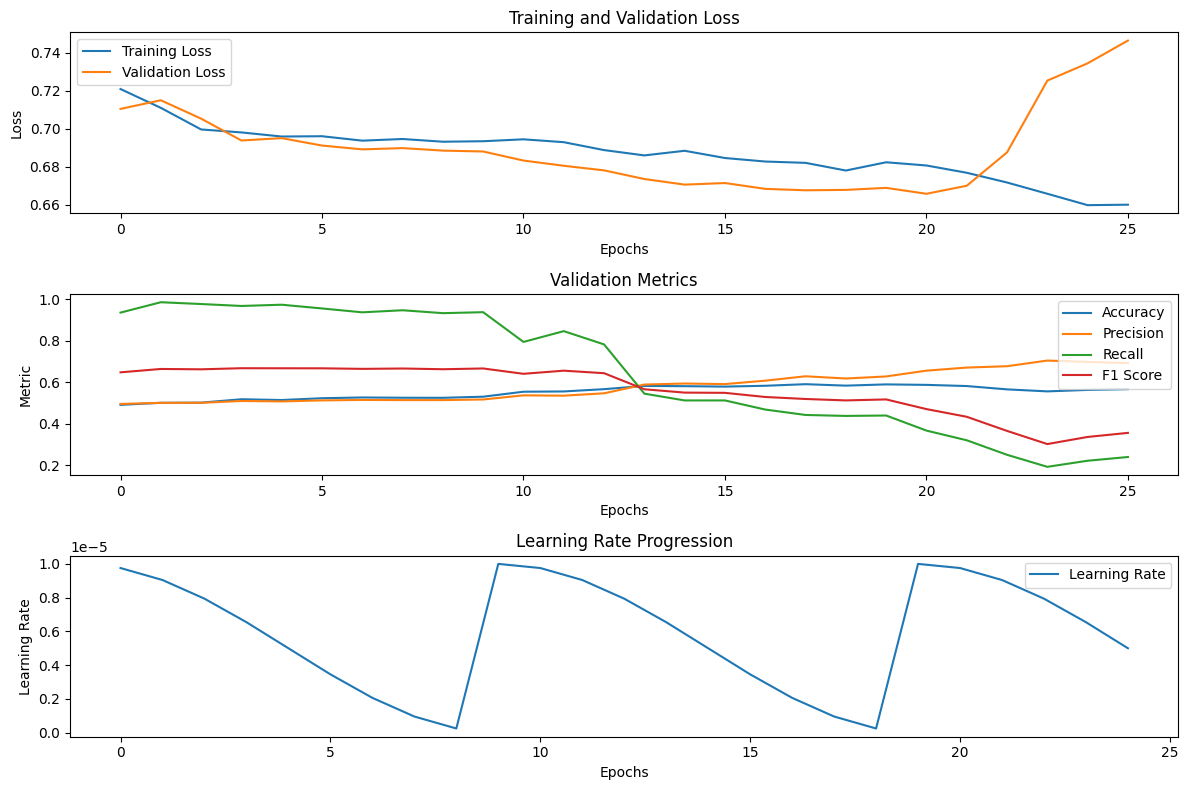

  2%|▏         | 1/48 [10:23<8:08:12, 623.25s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6943 at epoch 1

Epoch 1/100 - Training Loss: 0.7184 - Validation Loss: 0.6943 - Accuracy: 0.5107 - Precision: 0.5447 - Recall: 0.1300 - F1 Score: 0.2099 - Time: 24.08 - Lr: 9.76e-06
New best model with Loss: 0.6896 at epoch 2

Epoch 2/100 - Training Loss: 0.7122 - Validation Loss: 0.6896 - Accuracy: 0.5337 - Precision: 0.5618 - Recall: 0.3060 - F1 Score: 0.3962 - Time: 24.00 - Lr: 9.05e-06
New best model with Loss: 0.68

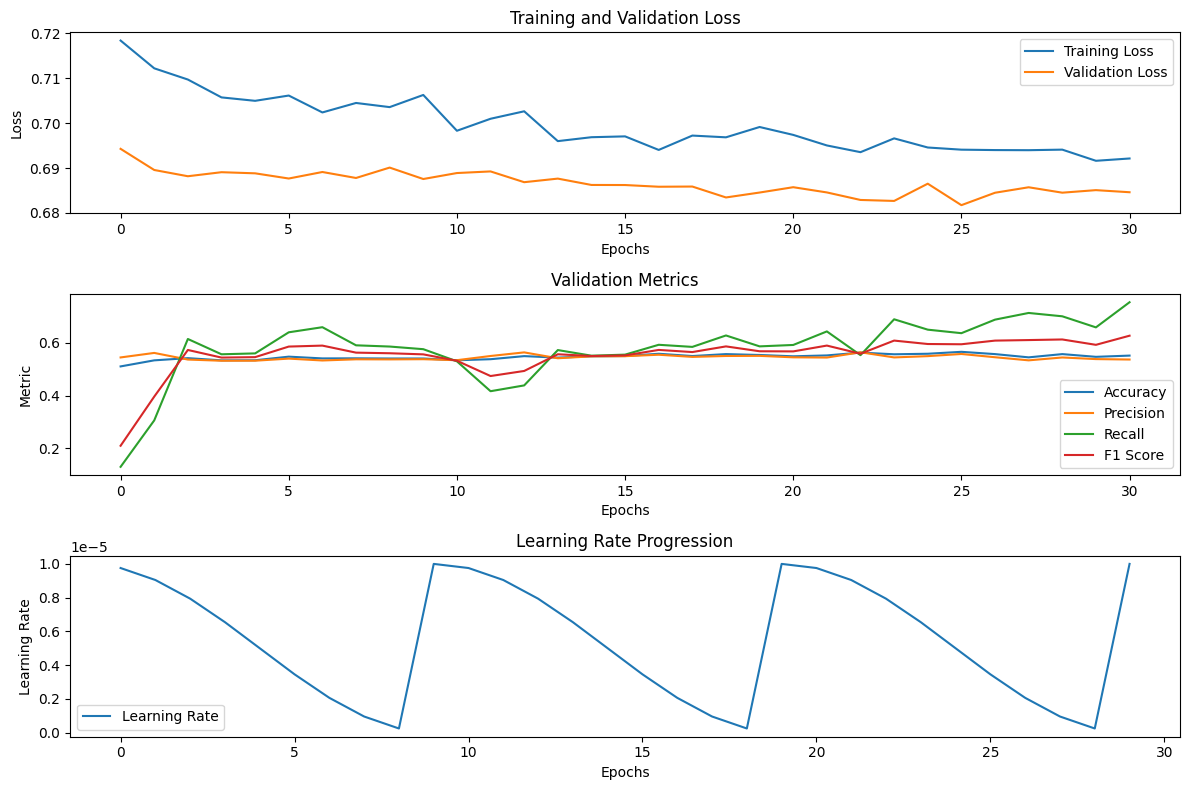

  4%|▍         | 2/48 [22:55<8:55:51, 698.94s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6910 at epoch 1

Epoch 1/100 - Training Loss: 0.7169 - Validation Loss: 0.6910 - Accuracy: 0.5183 - Precision: 0.5190 - Recall: 0.5013 - F1 Score: 0.5100 - Time: 25.04 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7060 - Validation Loss: 0.6914 - Accuracy: 0.5200 - Precision: 0.5110 - Recall: 0.9273 - F1 Score: 0.6589 - Time: 24.52 - Lr: 9.05e-06
New best model with Loss: 

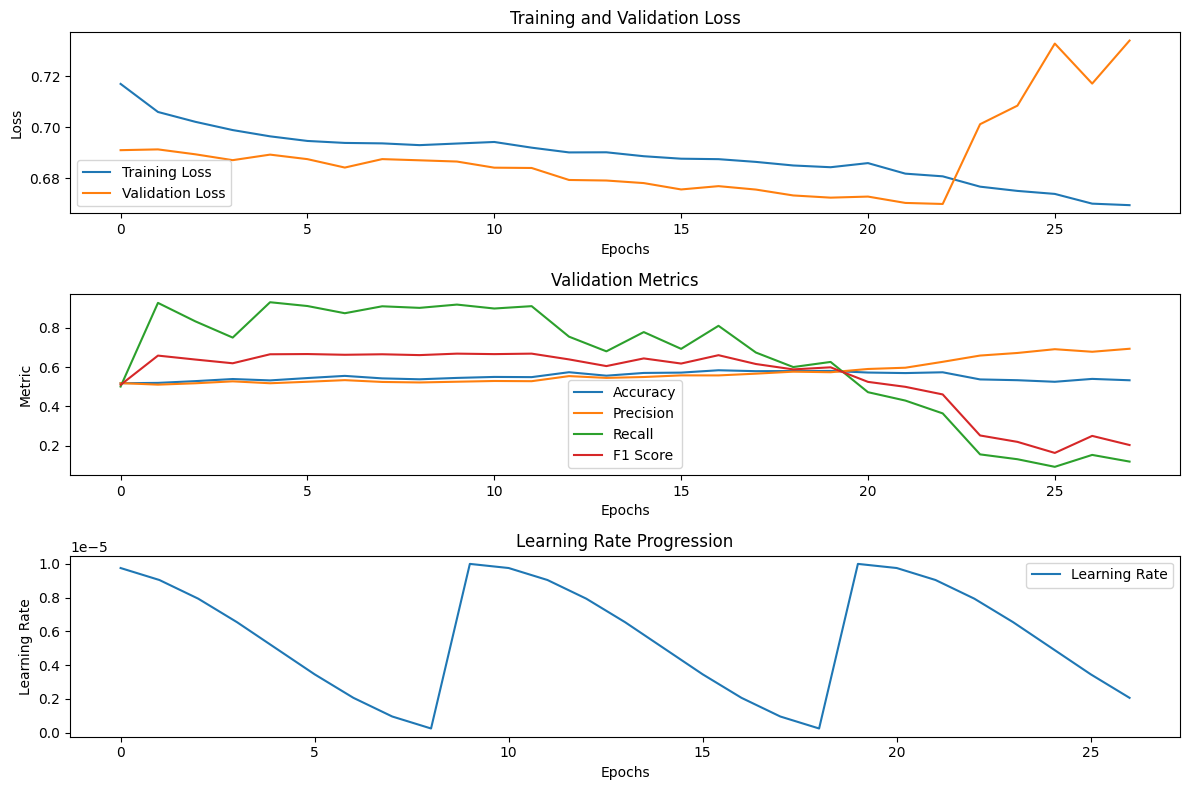

  6%|▋         | 3/48 [36:01<9:14:17, 739.06s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6971 at epoch 1

Epoch 1/100 - Training Loss: 0.7177 - Validation Loss: 0.6971 - Accuracy: 0.5210 - Precision: 0.5120 - Recall: 0.8953 - F1 Score: 0.6515 - Time: 33.55 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7152 - Validation Loss: 0.7016 - Accuracy: 0.5120 - Precision: 0.5063 - Recall: 0.9593 - F1 Score: 0.6628 - Time: 35.39 - Lr: 9.05e-06
New best model with Loss: 

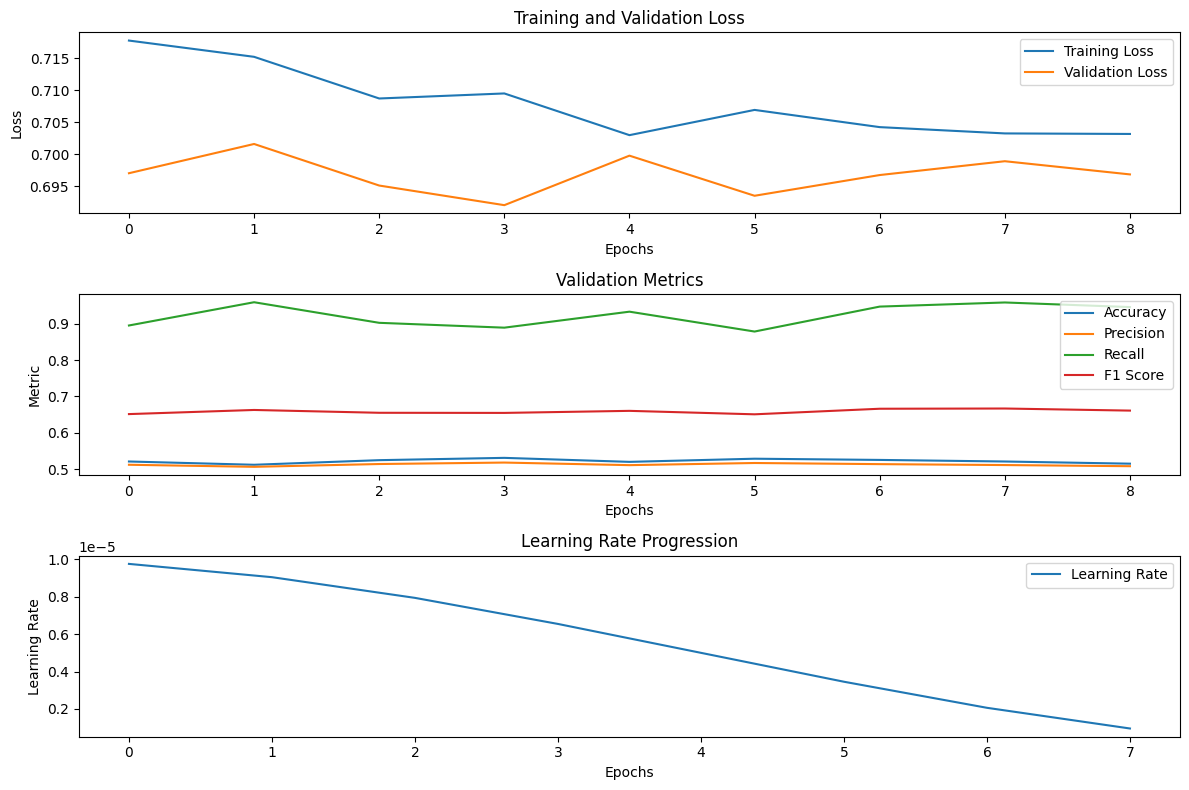

  8%|▊         | 4/48 [40:42<6:49:06, 557.88s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7102 at epoch 1

Epoch 1/100 - Training Loss: 0.7127 - Validation Loss: 0.7102 - Accuracy: 0.5007 - Precision: 0.5003 - Recall: 0.9893 - F1 Score: 0.6646 - Time: 26.58 - Lr: 9.76e-06
New best model with Loss: 0.7018 at epoch 2

Epoch 2/100 - Training Loss: 0.7025 - Validation Loss: 0.7018 - Accuracy: 0.4980 - Precision: 0.4989 - Recall: 0.9060 - F1 Score: 0.6435 - Time: 26.17 - Lr: 9.05e-06
Validation loss did not improv

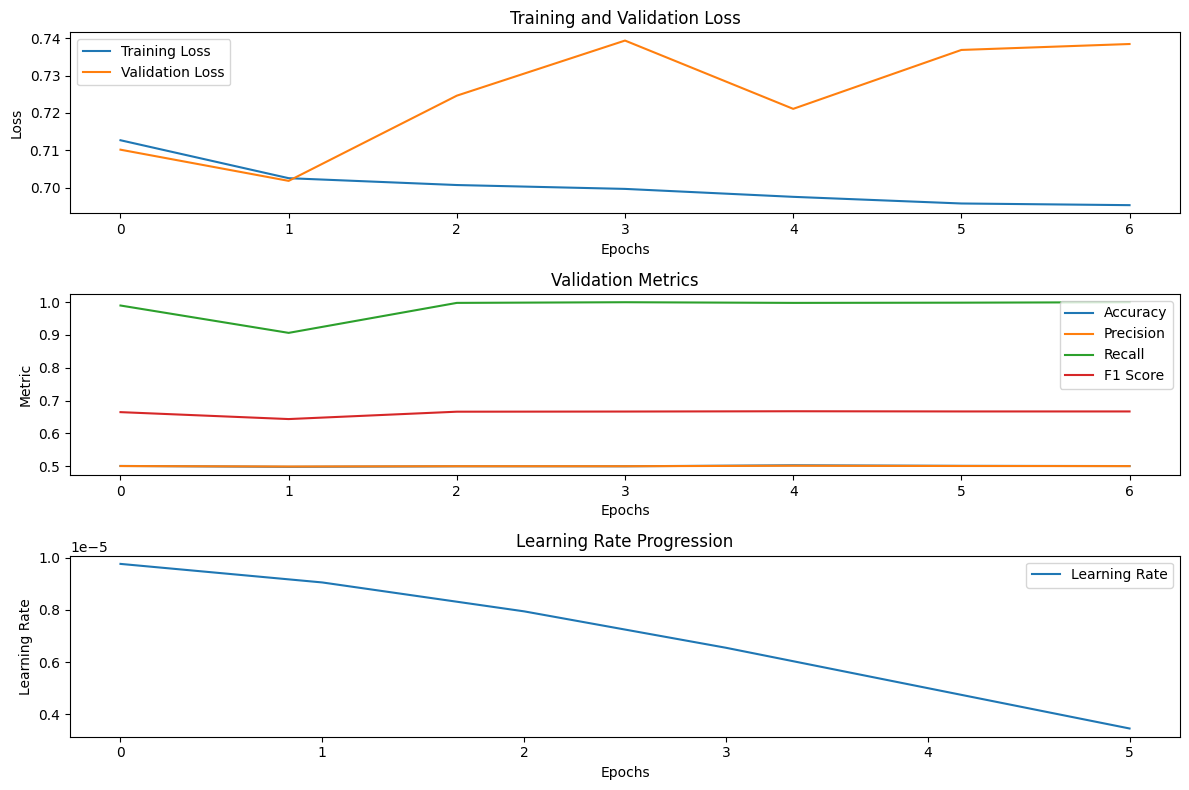

 10%|█         | 5/48 [43:46<5:03:18, 423.22s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7524 at epoch 1

Epoch 1/100 - Training Loss: 0.7213 - Validation Loss: 0.7524 - Accuracy: 0.5007 - Precision: 0.5003 - Recall: 1.0000 - F1 Score: 0.6670 - Time: 26.53 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7100 - Validation Loss: 0.7815 - Accuracy: 0.5007 - Precision: 0.5003 - Recall: 1.0000 - F1 Score: 0.6670 - Time: 25.40 - Lr: 9.05e-06
Validation loss did not im

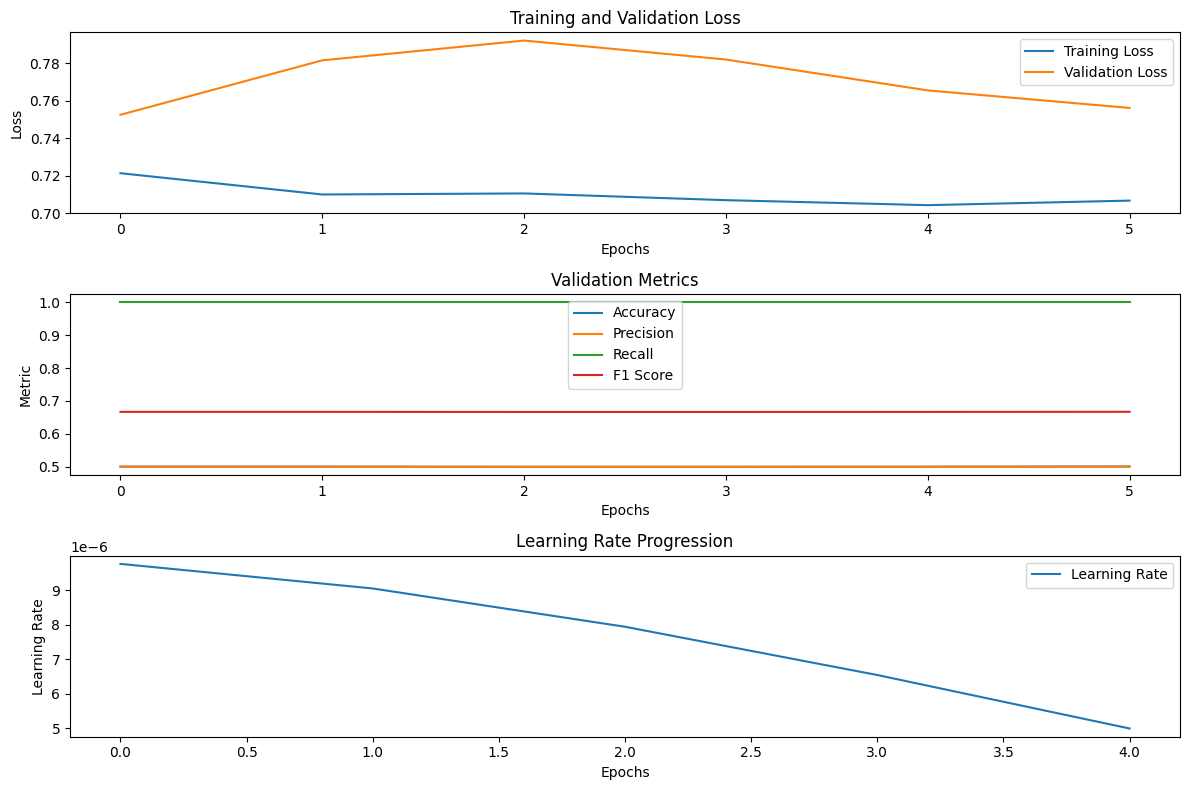

 12%|█▎        | 6/48 [46:21<3:52:27, 332.07s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7105 at epoch 1

Epoch 1/100 - Training Loss: 0.7048 - Validation Loss: 0.7105 - Accuracy: 0.5013 - Precision: 0.5007 - Recall: 0.9993 - F1 Score: 0.6671 - Time: 26.16 - Lr: 9.76e-06
New best model with Loss: 0.6954 at epoch 2

Epoch 2/100 - Training Loss: 0.6988 - Validation Loss: 0.6954 - Accuracy: 0.5083 - Precision: 0.5043 - Recall: 0.9827 - F1 Score: 0.6665 - Time: 25.99 - Lr: 9.05e-06
New best model with Loss: 0.69

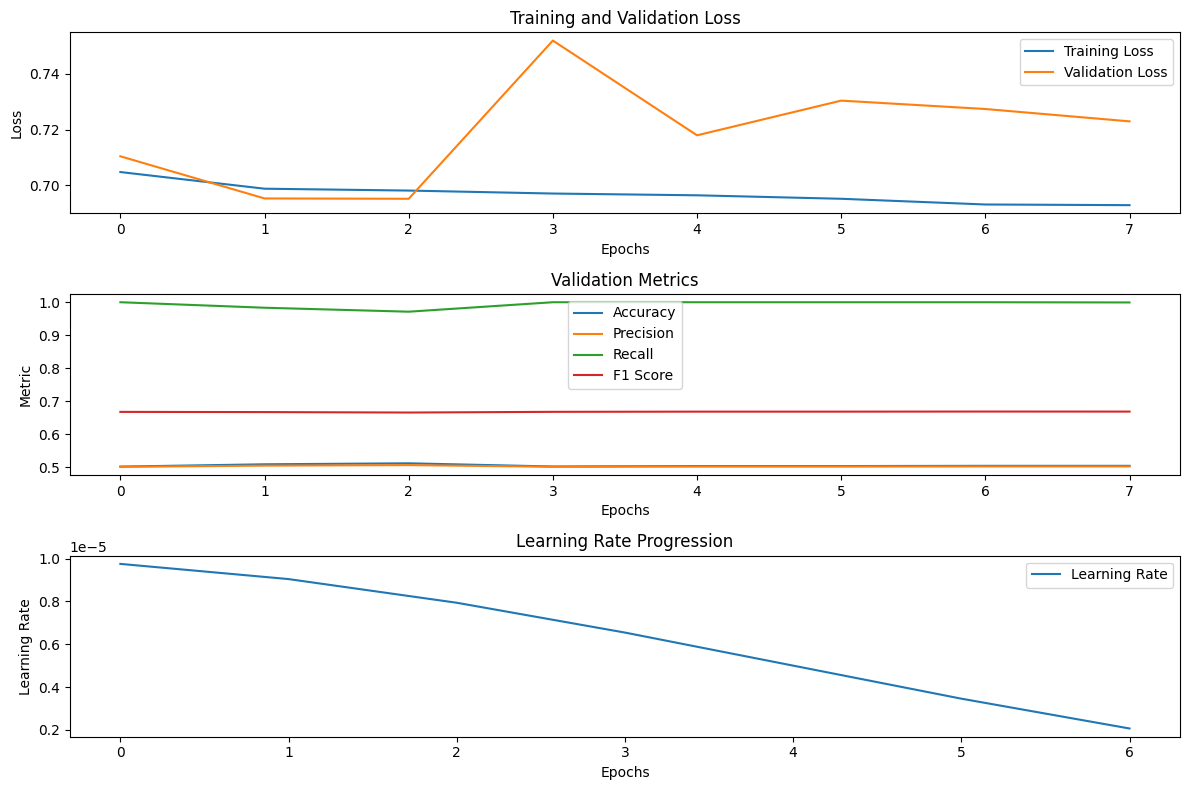

 15%|█▍        | 7/48 [49:49<3:19:10, 291.47s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7603 at epoch 1

Epoch 1/100 - Training Loss: 0.7243 - Validation Loss: 0.7603 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 26.41 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7150 - Validation Loss: 0.7638 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 26.05 - Lr: 9.05e-06
New best model with Loss: 

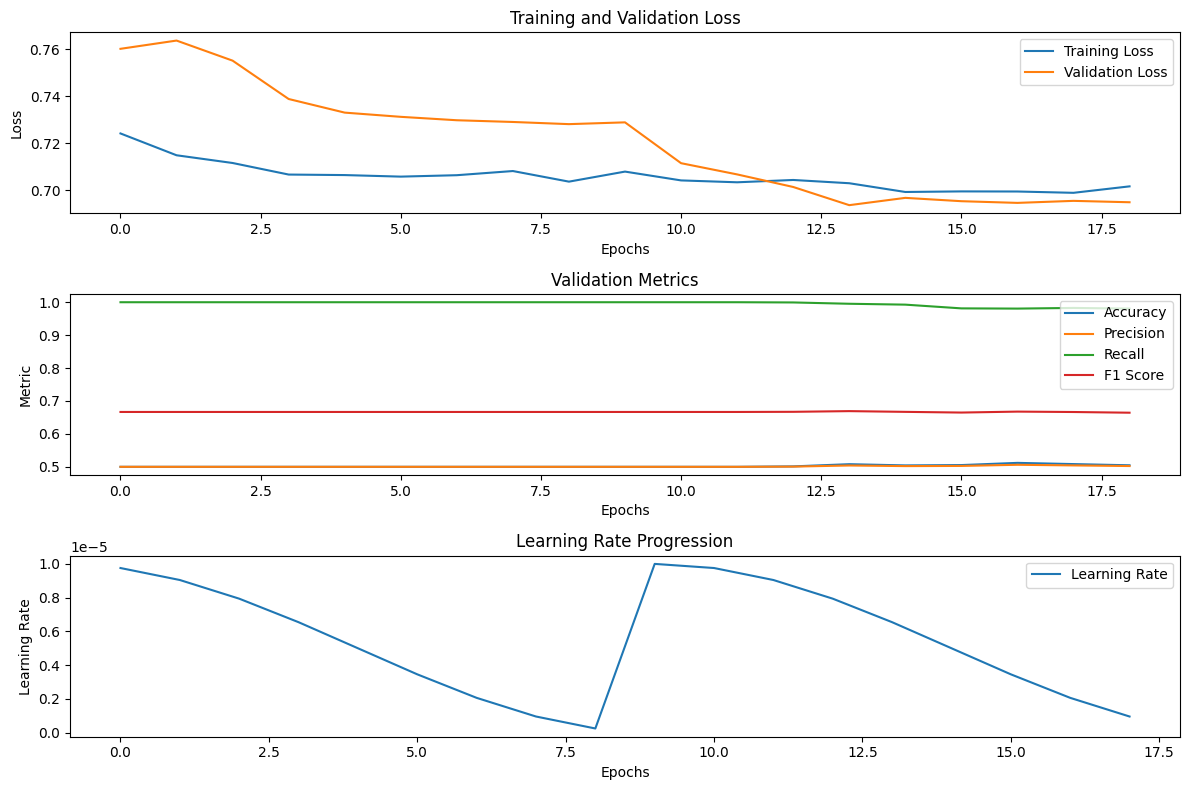

 17%|█▋        | 8/48 [58:06<3:57:58, 356.97s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6911 at epoch 1

Epoch 1/100 - Training Loss: 0.7084 - Validation Loss: 0.6911 - Accuracy: 0.5307 - Precision: 0.5228 - Recall: 0.7020 - F1 Score: 0.5993 - Time: 26.58 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7027 - Validation Loss: 0.7009 - Accuracy: 0.5087 - Precision: 0.5047 - Recall: 0.9307 - F1 Score: 0.6545 - Time: 26.02 - Lr: 9.05e-06
Validation loss did not im

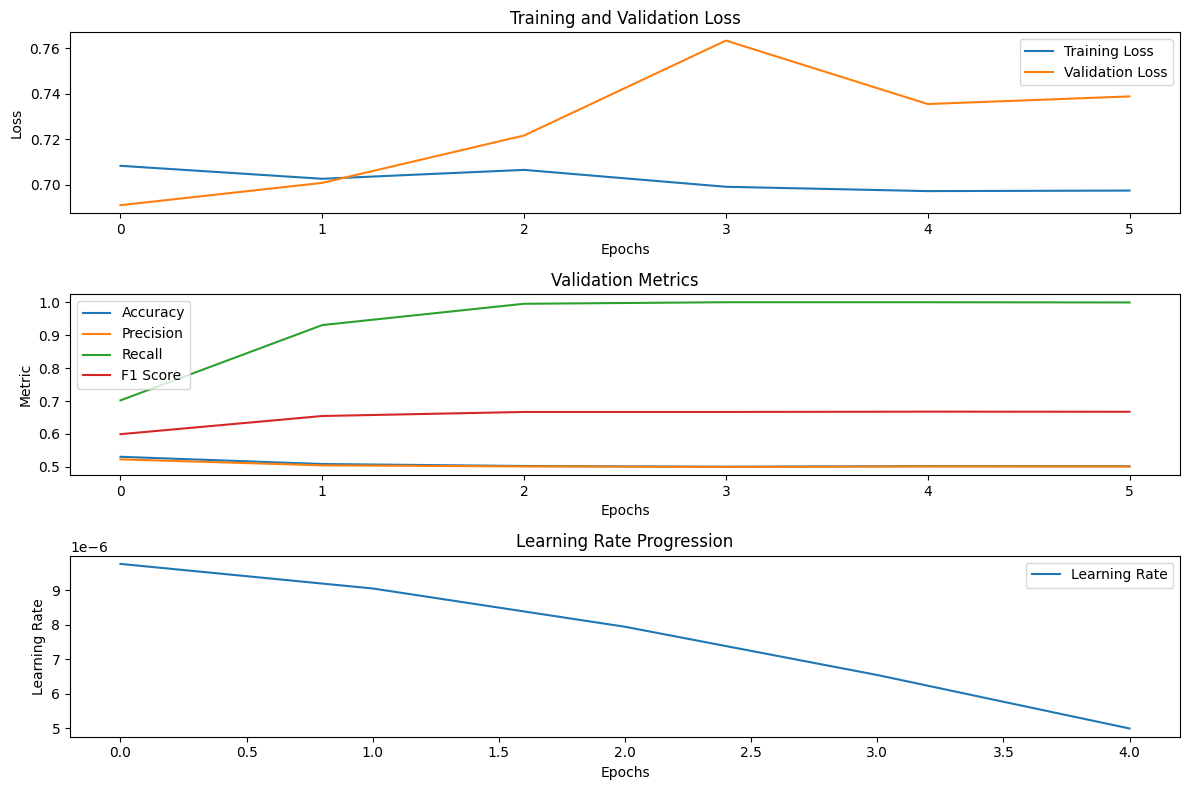

 19%|█▉        | 9/48 [1:00:45<3:11:46, 295.03s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7015 at epoch 1

Epoch 1/100 - Training Loss: 0.7280 - Validation Loss: 0.7015 - Accuracy: 0.4930 - Precision: 0.4907 - Recall: 0.3700 - F1 Score: 0.4219 - Time: 26.89 - Lr: 9.76e-06
New best model with Loss: 0.6982 at epoch 2

Epoch 2/100 - Training Loss: 0.7192 - Validation Loss: 0.6982 - Accuracy: 0.4977 - Precision: 0.4986 - Recall: 0.8547 - F1 Score: 0.6298 - Time: 26.53 - Lr: 9.05e-06
New best model with Loss: 0.69

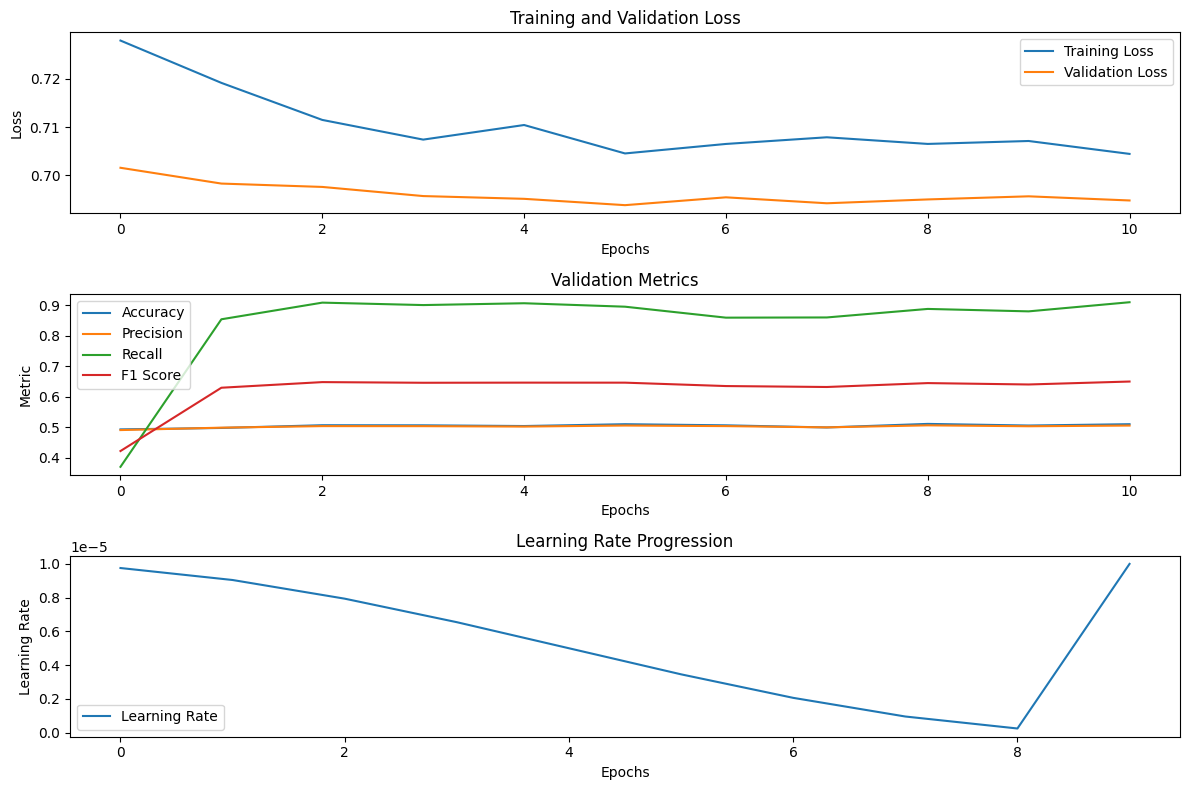

 21%|██        | 10/48 [1:05:38<3:06:21, 294.26s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7293 at epoch 1

Epoch 1/100 - Training Loss: 0.7052 - Validation Loss: 0.7293 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 27.09 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7000 - Validation Loss: 0.7363 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 26.54 - Lr: 9.05e-06
Validation loss did not im

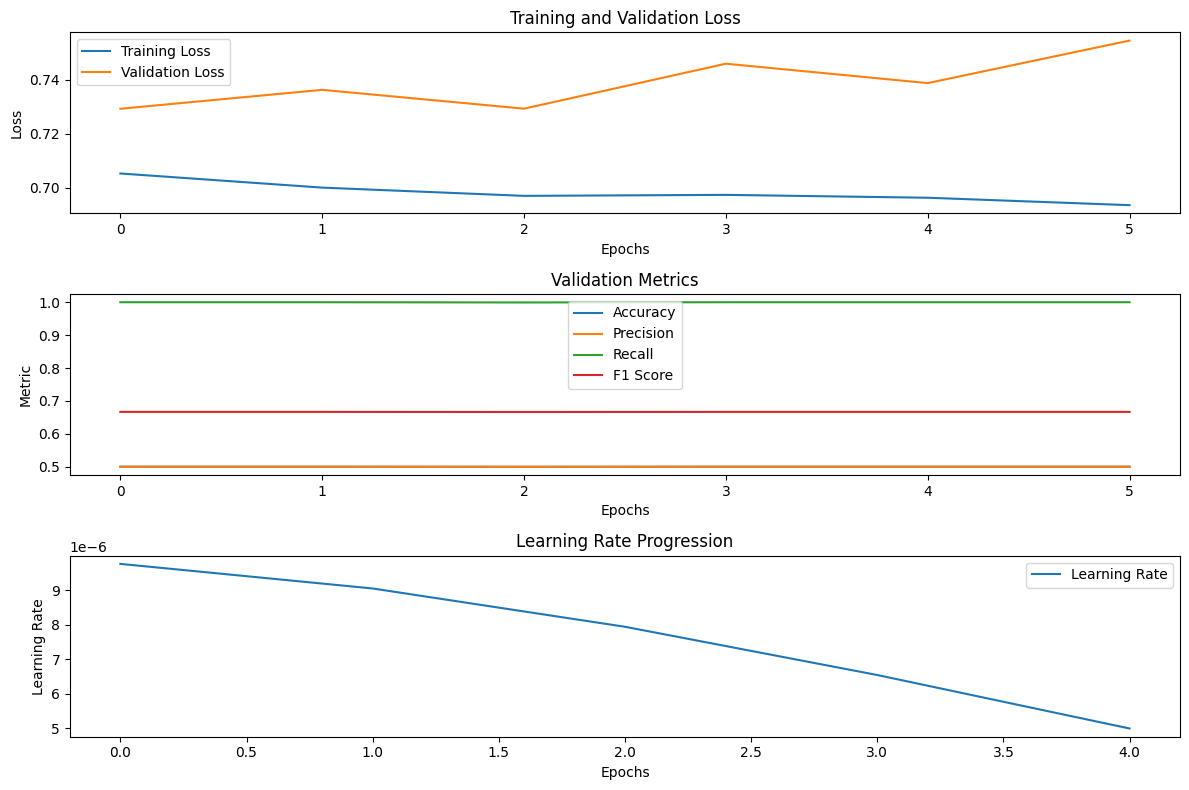

 23%|██▎       | 11/48 [1:08:17<2:35:59, 252.96s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7341 at epoch 1

Epoch 1/100 - Training Loss: 0.7119 - Validation Loss: 0.7341 - Accuracy: 0.5007 - Precision: 0.5003 - Recall: 0.9900 - F1 Score: 0.6647 - Time: 25.42 - Lr: 9.76e-06
New best model with Loss: 0.7116 at epoch 2

Epoch 2/100 - Training Loss: 0.7058 - Validation Loss: 0.7116 - Accuracy: 0.5027 - Precision: 0.5014 - Recall: 0.9280 - F1 Score: 0.6511 - Time: 24.24 - Lr: 9.05e-06
New best model with Loss: 0.69

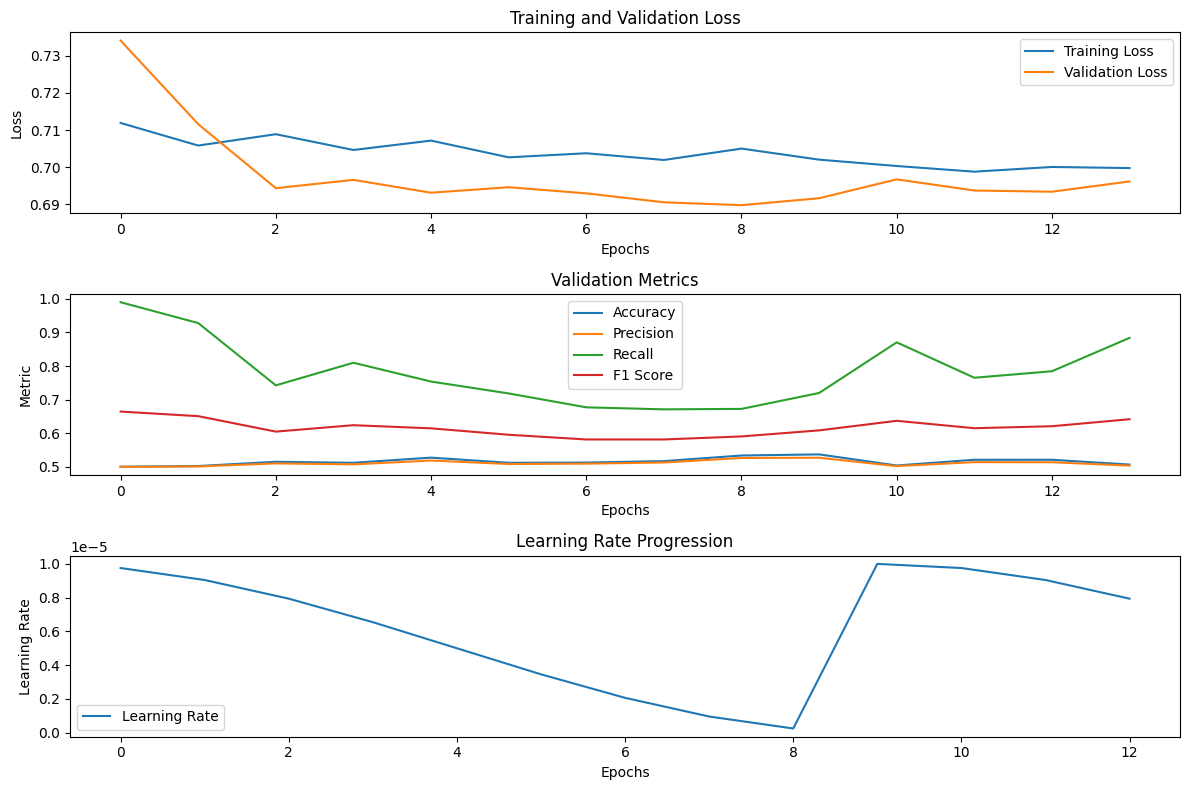

 25%|██▌       | 12/48 [1:14:02<2:48:33, 280.94s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6978 at epoch 1

Epoch 1/100 - Training Loss: 0.7175 - Validation Loss: 0.6978 - Accuracy: 0.5143 - Precision: 0.5080 - Recall: 0.9113 - F1 Score: 0.6524 - Time: 23.92 - Lr: 9.76e-06
New best model with Loss: 0.6977 at epoch 2

Epoch 2/100 - Training Loss: 0.7065 - Validation Loss: 0.6977 - Accuracy: 0.5247 - Precision: 0.5144 - Recall: 0.8820 - F1 Score: 0.6498 - Time: 24.70 - Lr: 9.05e-06
Validation loss did not improv

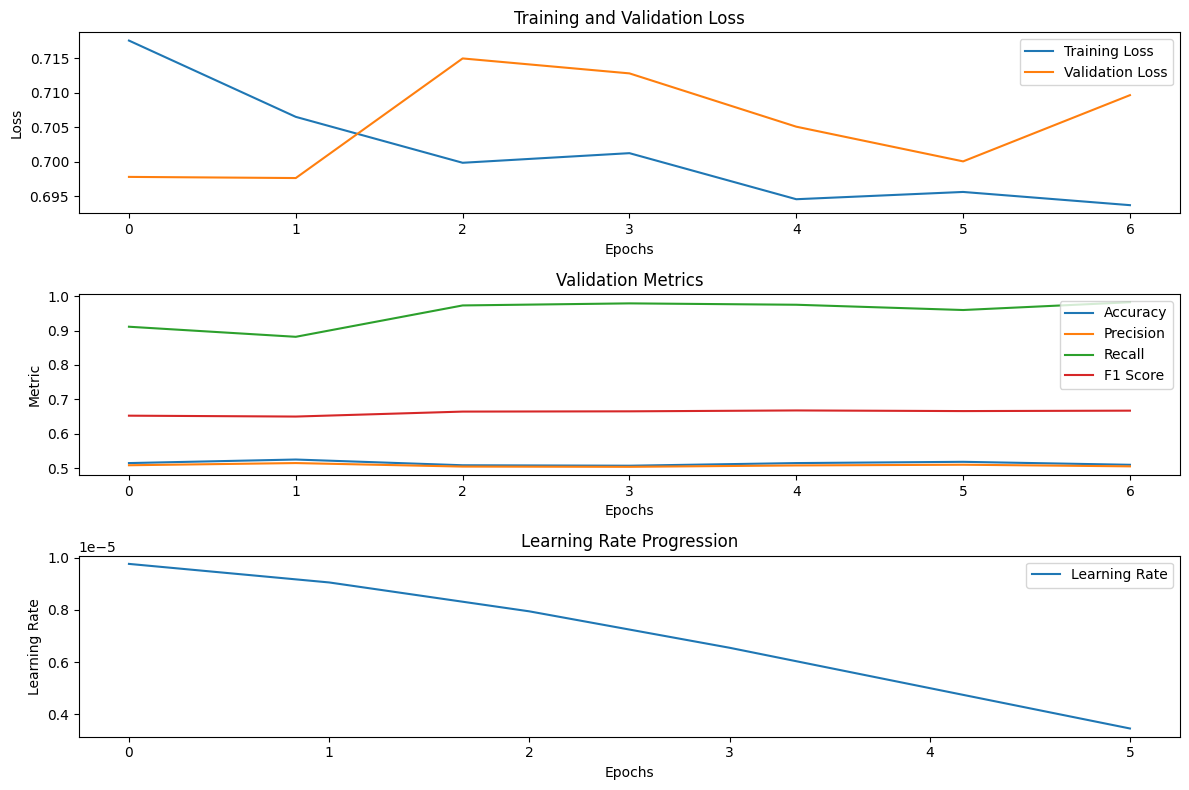

 27%|██▋       | 13/48 [1:16:58<2:25:18, 249.09s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6941 at epoch 1

Epoch 1/100 - Training Loss: 0.7274 - Validation Loss: 0.6941 - Accuracy: 0.5057 - Precision: 0.5034 - Recall: 0.8433 - F1 Score: 0.6305 - Time: 25.72 - Lr: 9.76e-06
New best model with Loss: 0.6909 at epoch 2

Epoch 2/100 - Training Loss: 0.7177 - Validation Loss: 0.6909 - Accuracy: 0.5330 - Precision: 0.5495 - Recall: 0.3667 - F1 Score: 0.4398 - Time: 25.37 - Lr: 9.05e-06
New best model with Loss: 0.69

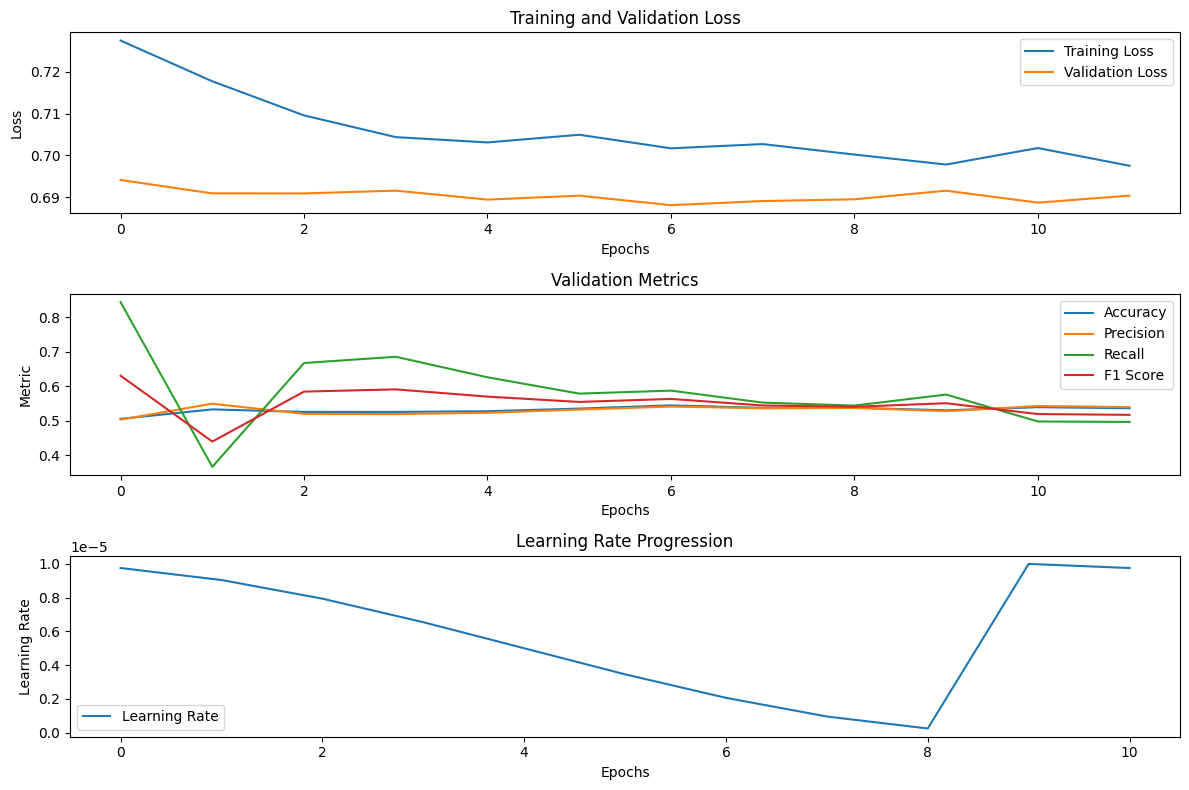

 29%|██▉       | 14/48 [1:21:53<2:29:06, 263.13s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6978 at epoch 1

Epoch 1/100 - Training Loss: 0.7127 - Validation Loss: 0.6978 - Accuracy: 0.4987 - Precision: 0.4993 - Recall: 0.9540 - F1 Score: 0.6555 - Time: 25.26 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7048 - Validation Loss: 0.6986 - Accuracy: 0.5030 - Precision: 0.5015 - Recall: 0.9740 - F1 Score: 0.6621 - Time: 26.06 - Lr: 9.05e-06
Validation loss did not im

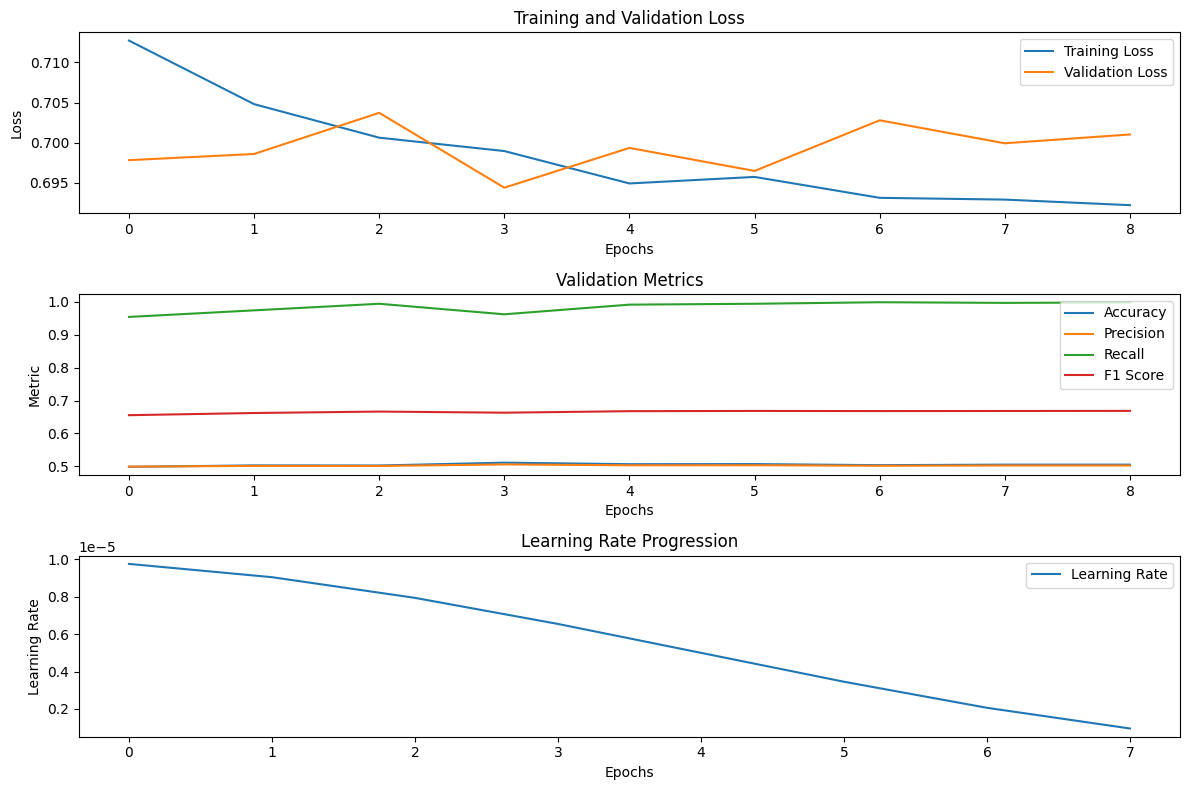

 31%|███▏      | 15/48 [1:25:48<2:20:01, 254.61s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7079 at epoch 1

Epoch 1/100 - Training Loss: 0.7152 - Validation Loss: 0.7079 - Accuracy: 0.4940 - Precision: 0.3676 - Recall: 0.0167 - F1 Score: 0.0319 - Time: 26.64 - Lr: 9.76e-06
New best model with Loss: 0.7076 at epoch 2

Epoch 2/100 - Training Loss: 0.7082 - Validation Loss: 0.7076 - Accuracy: 0.4963 - Precision: 0.3590 - Recall: 0.0093 - F1 Score: 0.0182 - Time: 26.30 - Lr: 9.05e-06
New best model with Loss: 0.70

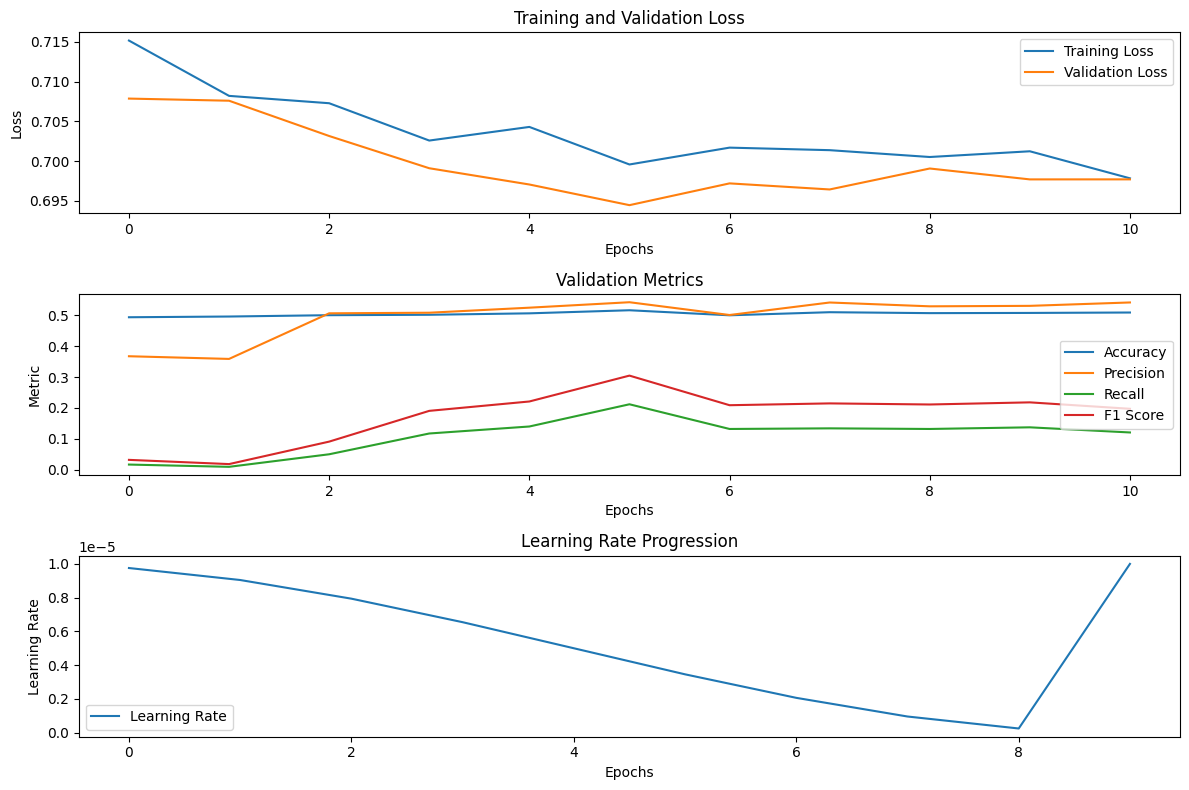

 33%|███▎      | 16/48 [1:30:40<2:21:42, 265.69s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6939 at epoch 1

Epoch 1/100 - Training Loss: 0.7140 - Validation Loss: 0.6939 - Accuracy: 0.5197 - Precision: 0.5125 - Recall: 0.8073 - F1 Score: 0.6270 - Time: 27.03 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7020 - Validation Loss: 0.6956 - Accuracy: 0.5150 - Precision: 0.5084 - Recall: 0.9067 - F1 Score: 0.6515 - Time: 27.94 - Lr: 9.05e-06
New best model with Loss: 

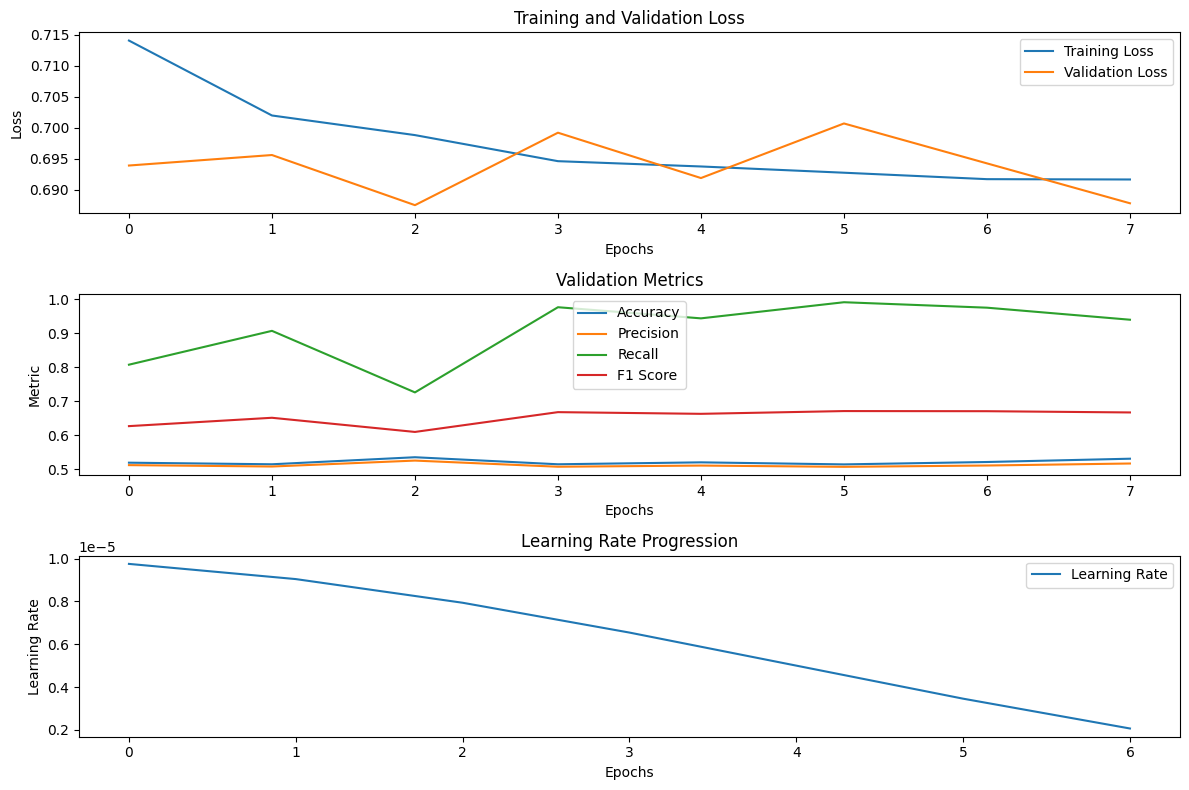

 35%|███▌      | 17/48 [1:34:19<2:10:07, 251.87s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7078 at epoch 1

Epoch 1/100 - Training Loss: 0.7209 - Validation Loss: 0.7078 - Accuracy: 0.5003 - Precision: 0.5002 - Recall: 0.9593 - F1 Score: 0.6575 - Time: 27.08 - Lr: 9.76e-06
New best model with Loss: 0.7012 at epoch 2

Epoch 2/100 - Training Loss: 0.7154 - Validation Loss: 0.7012 - Accuracy: 0.4990 - Precision: 0.4994 - Recall: 0.9027 - F1 Score: 0.6431 - Time: 26.56 - Lr: 9.05e-06
New best model with Loss: 0.69

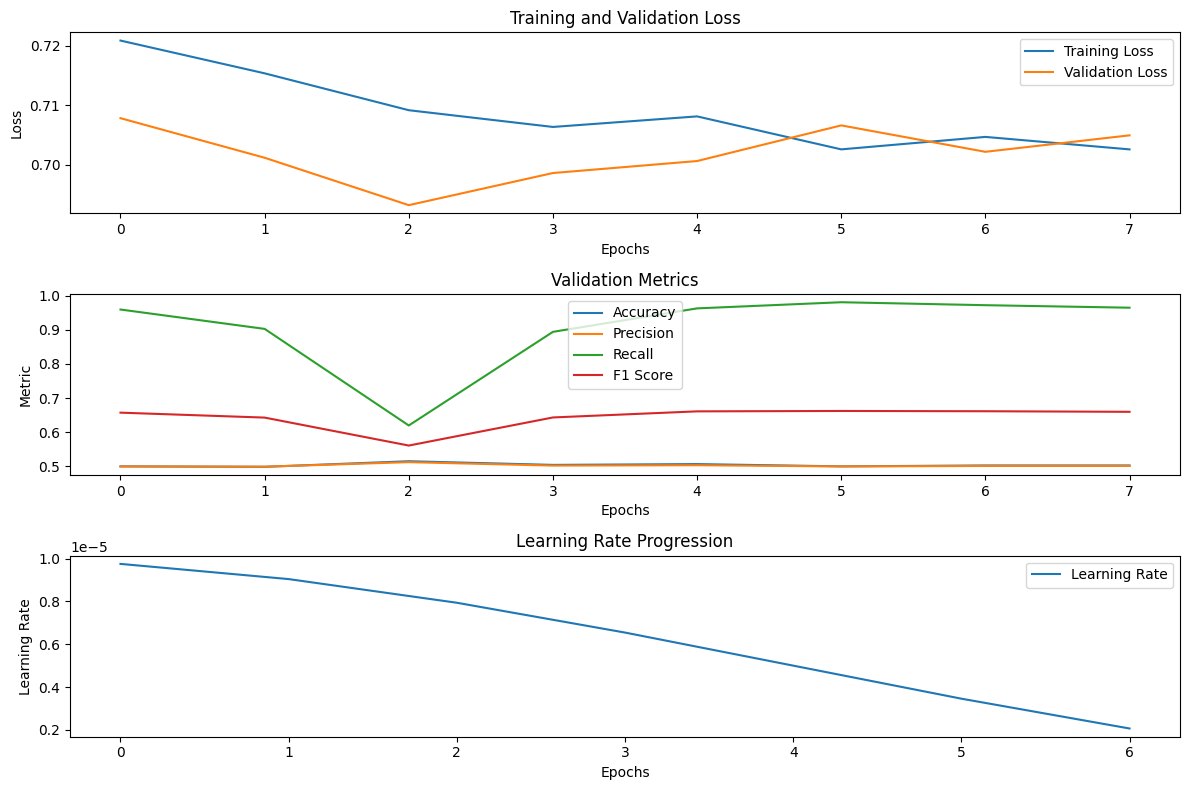

 38%|███▊      | 18/48 [1:37:54<2:00:25, 240.84s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7002 at epoch 1

Epoch 1/100 - Training Loss: 0.7073 - Validation Loss: 0.7002 - Accuracy: 0.5047 - Precision: 0.5024 - Recall: 0.9800 - F1 Score: 0.6643 - Time: 27.00 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7038 - Validation Loss: 0.7104 - Accuracy: 0.5027 - Precision: 0.5013 - Recall: 0.9987 - F1 Score: 0.6676 - Time: 26.84 - Lr: 9.05e-06
Validation loss did not im

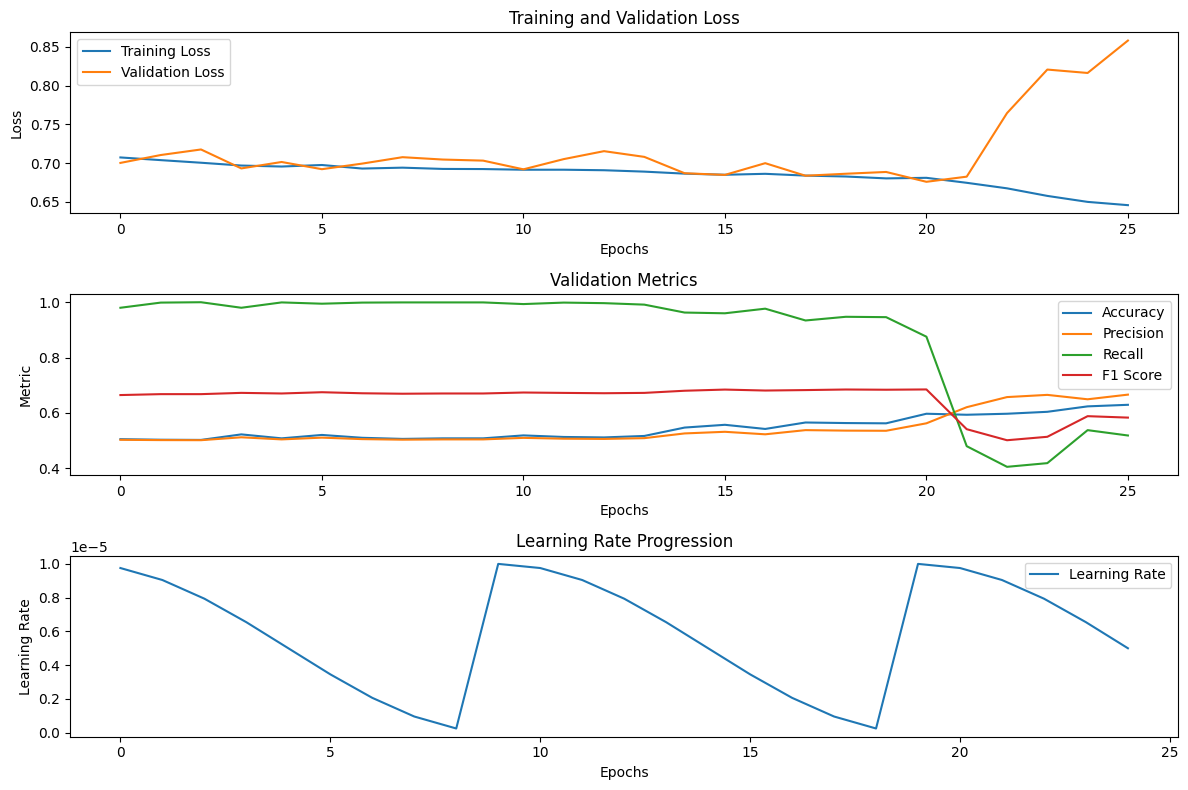

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...


 40%|███▉      | 19/48 [1:49:37<3:03:29, 379.63s/it]

Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7517 at epoch 1

Epoch 1/100 - Training Loss: 0.7159 - Validation Loss: 0.7517 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 27.82 - Lr: 9.76e-06
New best model with Loss: 0.7203 at epoch 2

Epoch 2/100 - Training Loss: 0.7149 - Validation Loss: 0.7203 - Accuracy: 0.4997 - Precision: 0.4998 - Recall: 0.9993 - F1 Score: 0.6664 - Time: 27.32 - Lr: 9.05e-06
Validation loss did not improve for 1 epoch(s).

Epoch 3/100 - Training Loss: 0.7098 - Validation Loss: 0.7266 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 26.73 - Lr: 7.94e-06
Validation loss did not improve for 2 epoch(s).

Epoch 4/100 - Training Loss: 0.7027 - Validation Loss

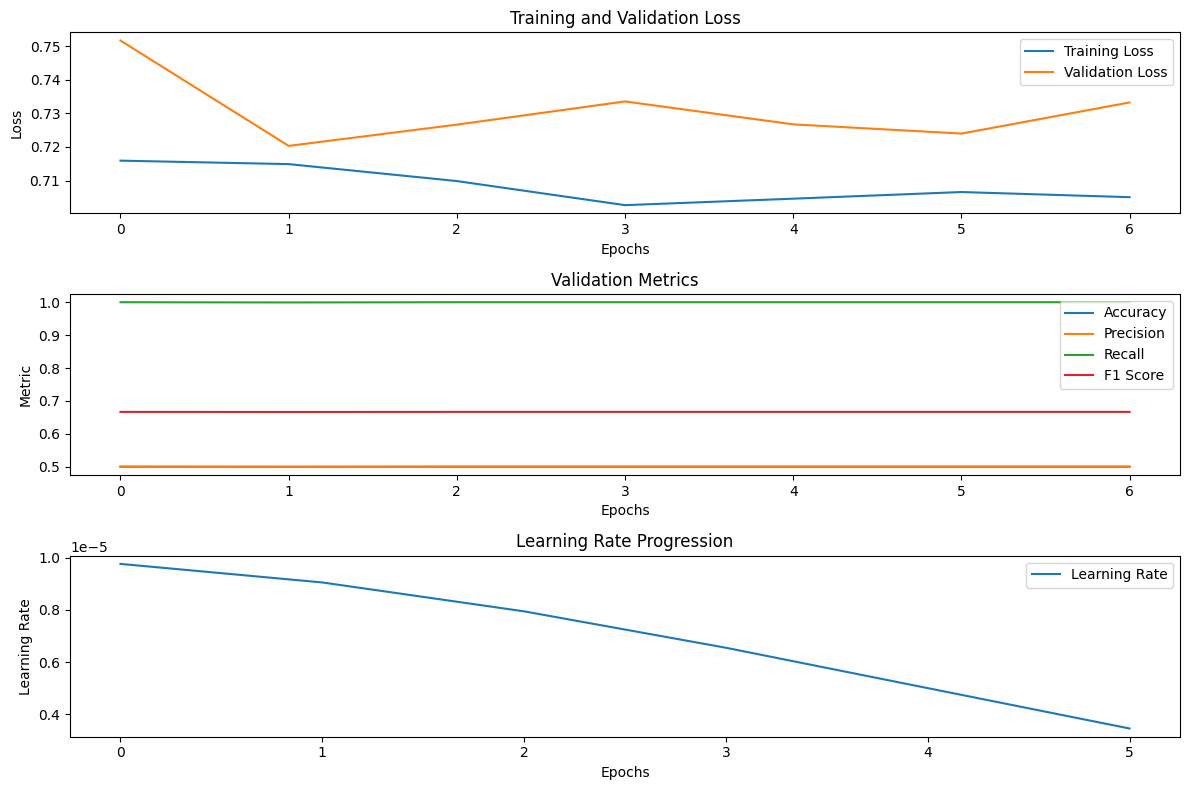

 42%|████▏     | 20/48 [1:52:49<2:30:46, 323.10s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7262 at epoch 1

Epoch 1/100 - Training Loss: 0.7121 - Validation Loss: 0.7262 - Accuracy: 0.5010 - Precision: 0.5005 - Recall: 0.9913 - F1 Score: 0.6652 - Time: 27.84 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7086 - Validation Loss: 0.8300 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 27.34 - Lr: 9.05e-06
Validation loss did not im

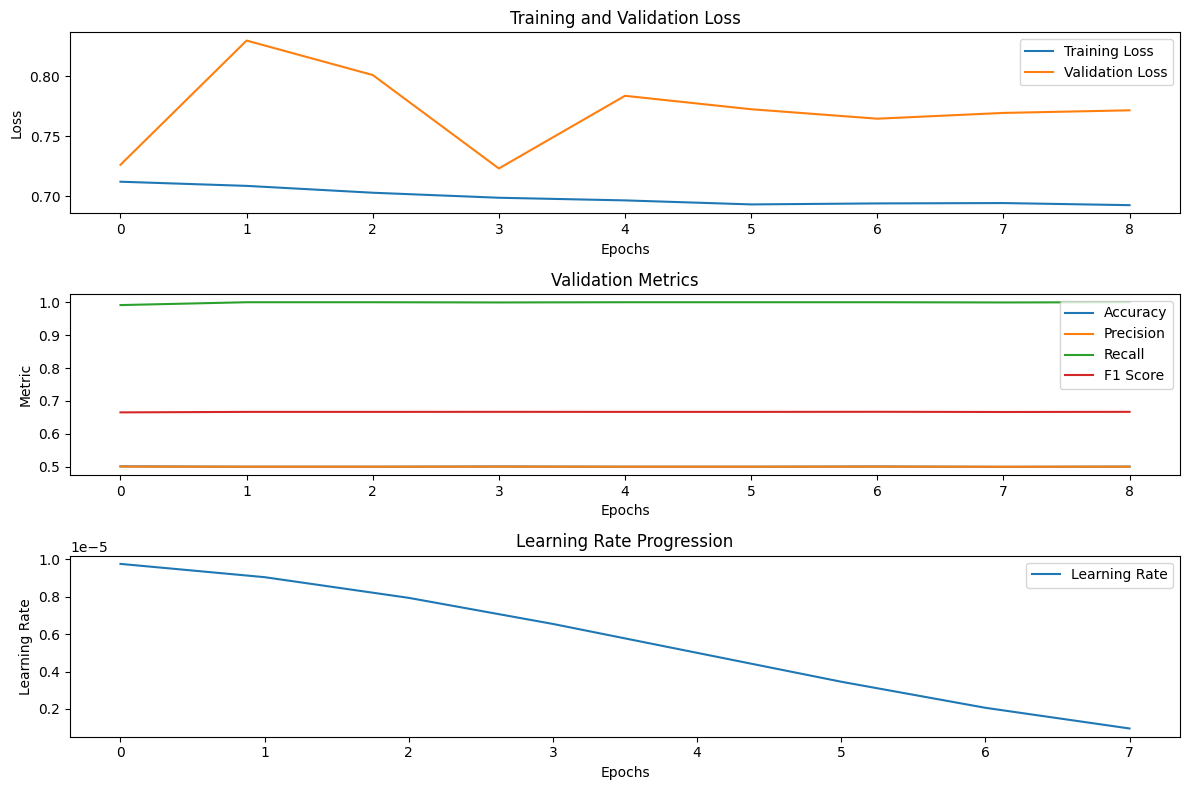

 44%|████▍     | 21/48 [1:56:56<2:15:09, 300.33s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.8404 at epoch 1

Epoch 1/100 - Training Loss: 0.7182 - Validation Loss: 0.8404 - Accuracy: 0.5003 - Precision: 0.6667 - Recall: 0.0013 - F1 Score: 0.0027 - Time: 27.90 - Lr: 9.76e-06
New best model with Loss: 0.8236 at epoch 2

Epoch 2/100 - Training Loss: 0.7127 - Validation Loss: 0.8236 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.0013 - F1 Score: 0.0027 - Time: 25.57 - Lr: 9.05e-06
New best model with Loss: 0.80

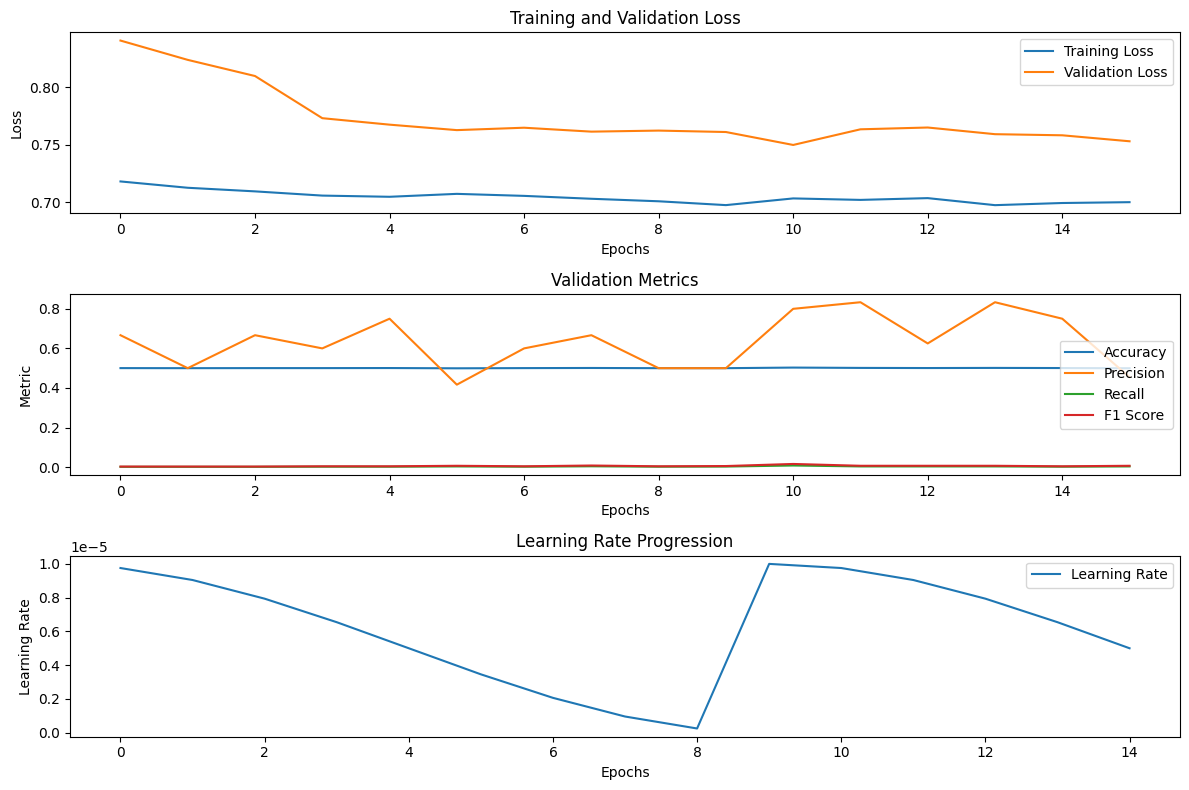

 46%|████▌     | 22/48 [2:03:36<2:23:06, 330.27s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6963 at epoch 1

Epoch 1/100 - Training Loss: 0.7072 - Validation Loss: 0.6963 - Accuracy: 0.4947 - Precision: 0.4924 - Recall: 0.3453 - F1 Score: 0.4060 - Time: 25.10 - Lr: 9.76e-06
New best model with Loss: 0.6940 at epoch 2

Epoch 2/100 - Training Loss: 0.7001 - Validation Loss: 0.6940 - Accuracy: 0.5137 - Precision: 0.5190 - Recall: 0.3740 - F1 Score: 0.4347 - Time: 24.78 - Lr: 9.05e-06
Validation loss did not improv

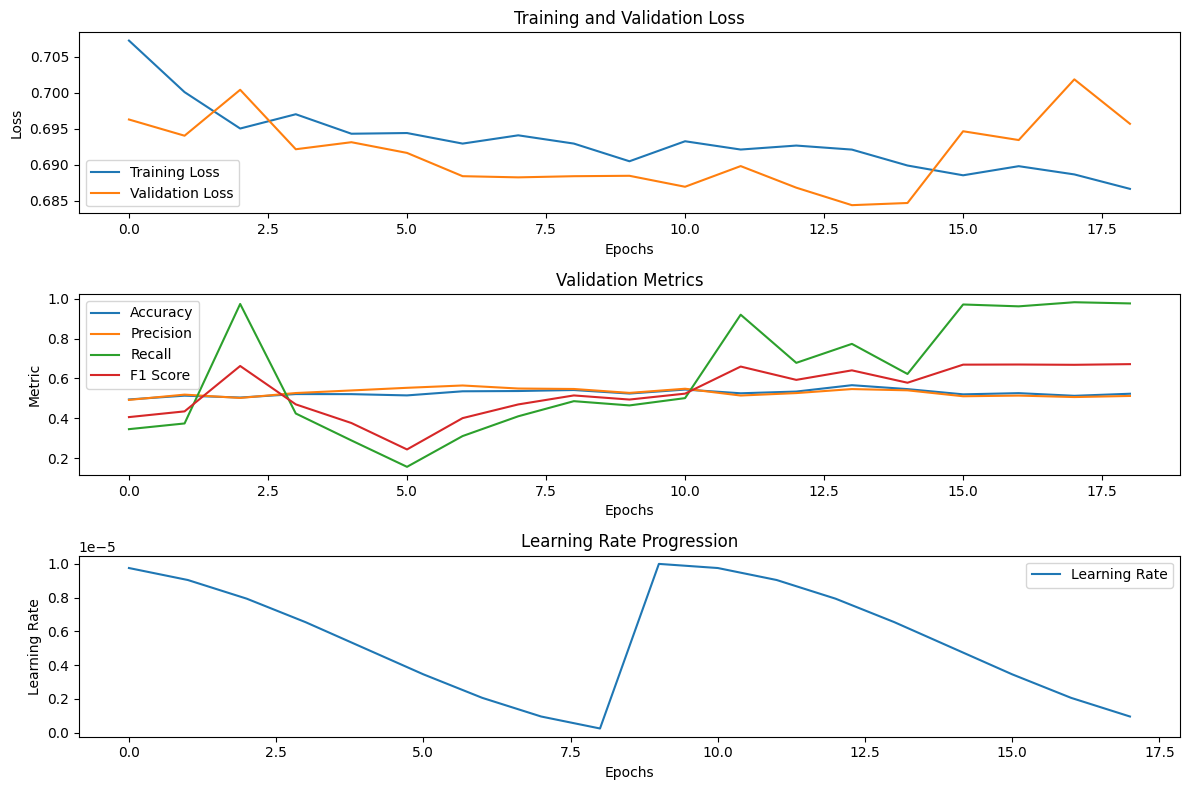

 48%|████▊     | 23/48 [2:11:27<2:35:15, 372.62s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7108 at epoch 1

Epoch 1/100 - Training Loss: 0.7173 - Validation Loss: 0.7108 - Accuracy: 0.5020 - Precision: 0.5010 - Recall: 0.9947 - F1 Score: 0.6664 - Time: 26.07 - Lr: 9.76e-06
New best model with Loss: 0.6981 at epoch 2

Epoch 2/100 - Training Loss: 0.7117 - Validation Loss: 0.6981 - Accuracy: 0.4977 - Precision: 0.4988 - Recall: 0.9373 - F1 Score: 0.6511 - Time: 25.43 - Lr: 9.05e-06
New best model with Loss: 0.69

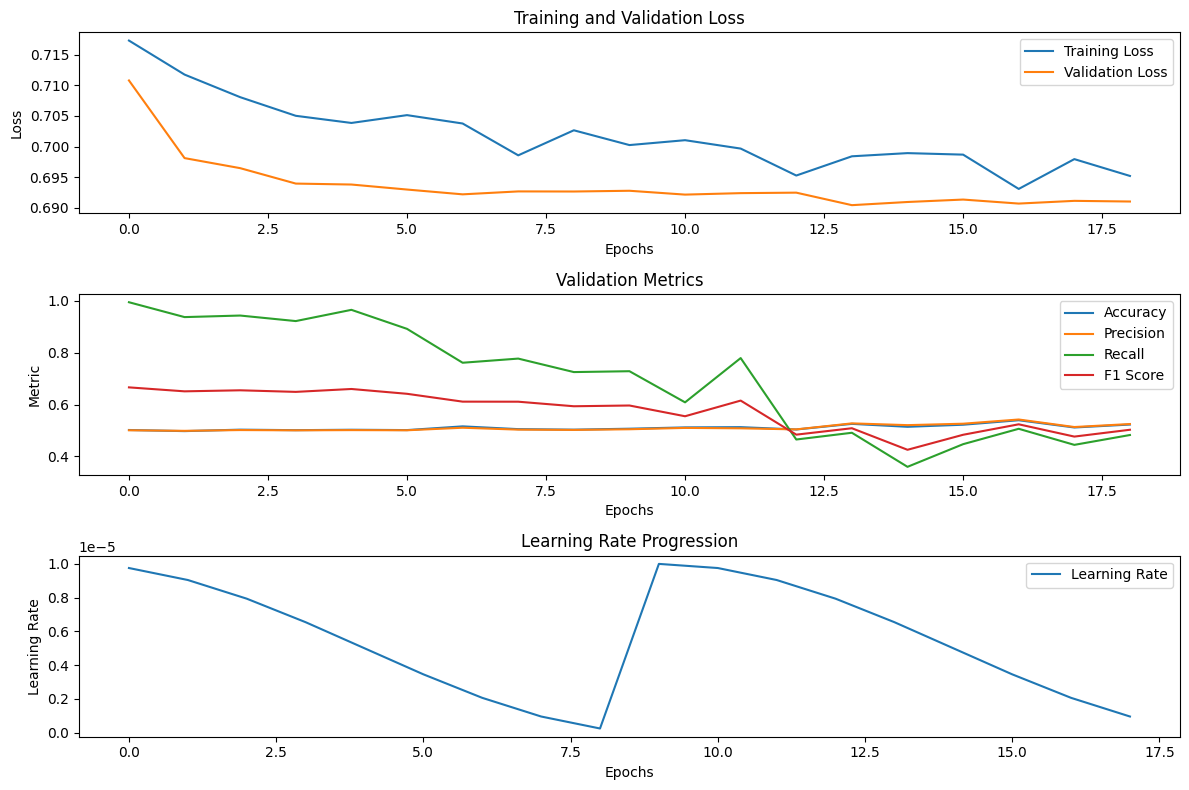

 50%|█████     | 24/48 [2:20:44<2:51:07, 427.80s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 2, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6909 at epoch 1

Epoch 1/100 - Training Loss: 0.7121 - Validation Loss: 0.6909 - Accuracy: 0.5273 - Precision: 0.5190 - Recall: 0.7460 - F1 Score: 0.6121 - Time: 31.05 - Lr: 9.76e-06
New best model with Loss: 0.6876 at epoch 2

Epoch 2/100 - Training Loss: 0.7045 - Validation Loss: 0.6876 - Accuracy: 0.5410 - Precision: 0.5282 - Recall: 0.7687 - F1 Score: 0.6261 - Time: 29.87 - Lr: 9.05e-06
Validation loss did not improv

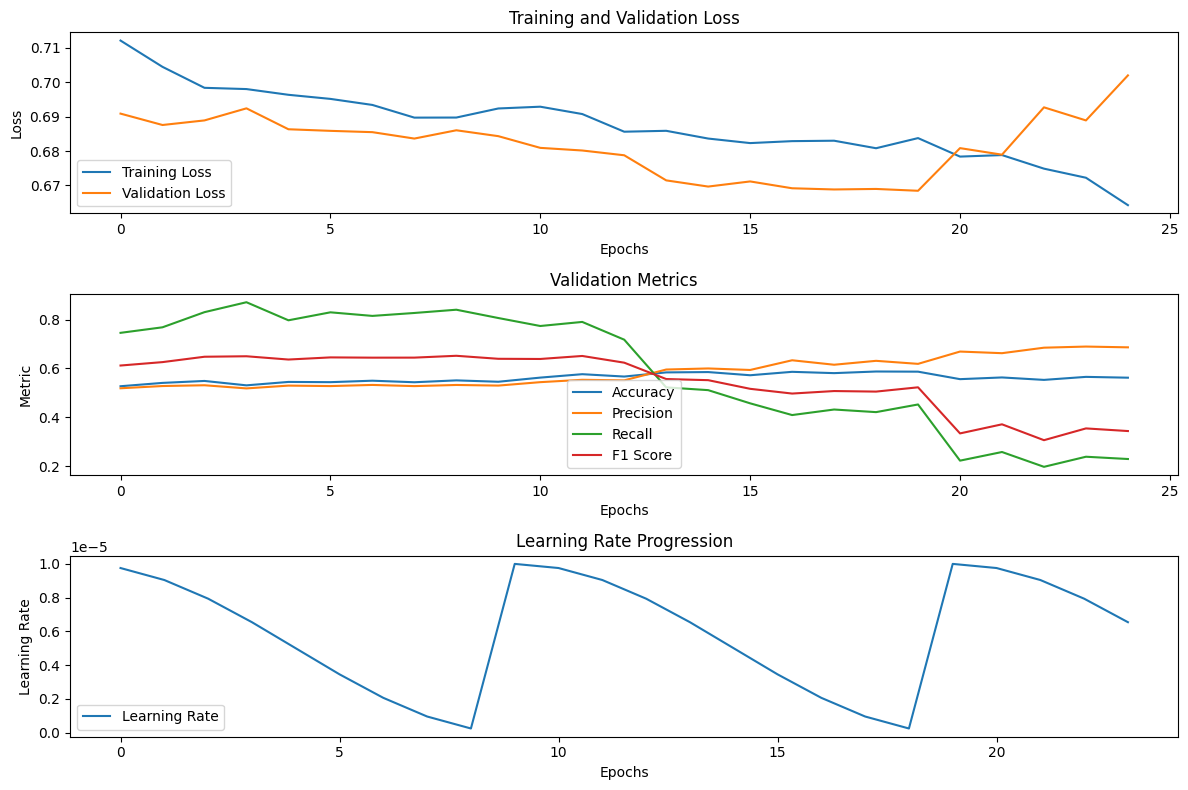

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...


 52%|█████▏    | 25/48 [2:32:50<3:18:14, 517.15s/it]

Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6905 at epoch 1

Epoch 1/100 - Training Loss: 0.7145 - Validation Loss: 0.6905 - Accuracy: 0.5280 - Precision: 0.5254 - Recall: 0.5787 - F1 Score: 0.5508 - Time: 32.16 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7143 - Validation Loss: 0.6954 - Accuracy: 0.5173 - Precision: 0.5105 - Recall: 0.8420 - F1 Score: 0.6356 - Time: 29.63 - Lr: 9.05e-06
New best model with Loss: 0.6895 at epoch 3

Epoch 3/100 - Training Loss: 0.7135 - Validation Loss: 0.6895 - Accuracy: 0.5270 - Precision: 0.5198 - Recall: 0.7093 - F1 Score: 0.5999 - Time: 31.35 - Lr: 7.94e-06
New best model with Loss: 0.6878 at epoch 4

Epoch 4/100 - Training Loss: 0.7085 - Validation Loss: 0.

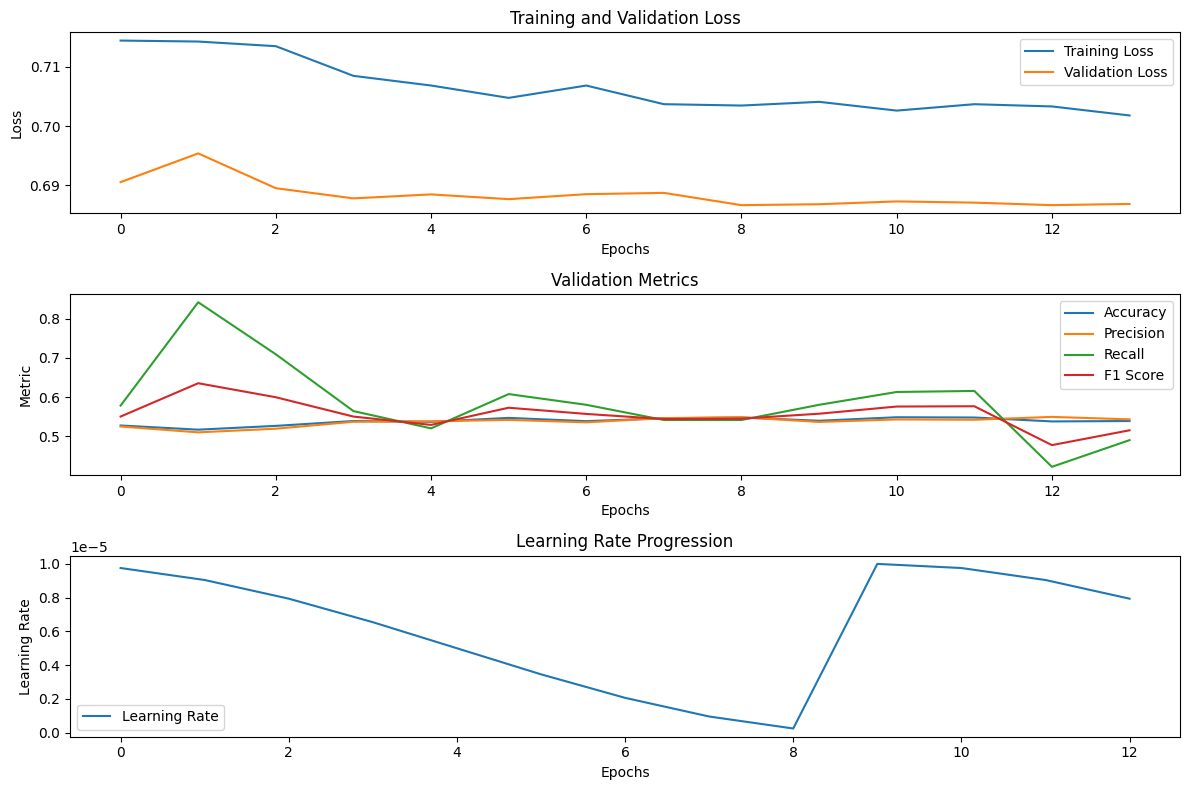

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...


 54%|█████▍    | 26/48 [2:39:57<2:59:46, 490.27s/it]

Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6961 at epoch 1

Epoch 1/100 - Training Loss: 0.7081 - Validation Loss: 0.6961 - Accuracy: 0.5007 - Precision: 0.5004 - Recall: 0.9347 - F1 Score: 0.6518 - Time: 28.42 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7021 - Validation Loss: 0.7001 - Accuracy: 0.5003 - Precision: 0.5002 - Recall: 0.9967 - F1 Score: 0.6661 - Time: 28.10 - Lr: 9.05e-06
New best model with Loss: 0.6946 at epoch 3

Epoch 3/100 - Training Loss: 0.6999 - Validation Loss: 0.6946 - Accuracy: 0.5050 - Precision: 0.5027 - Recall: 0.9320 - F1 Score: 0.6531 - Time: 28.57 - Lr: 7.94e-06
New best model with Loss: 0.6918 at epoch 4

Epoch 4/100 - Training Loss: 0.6987 - Validation Loss: 0.

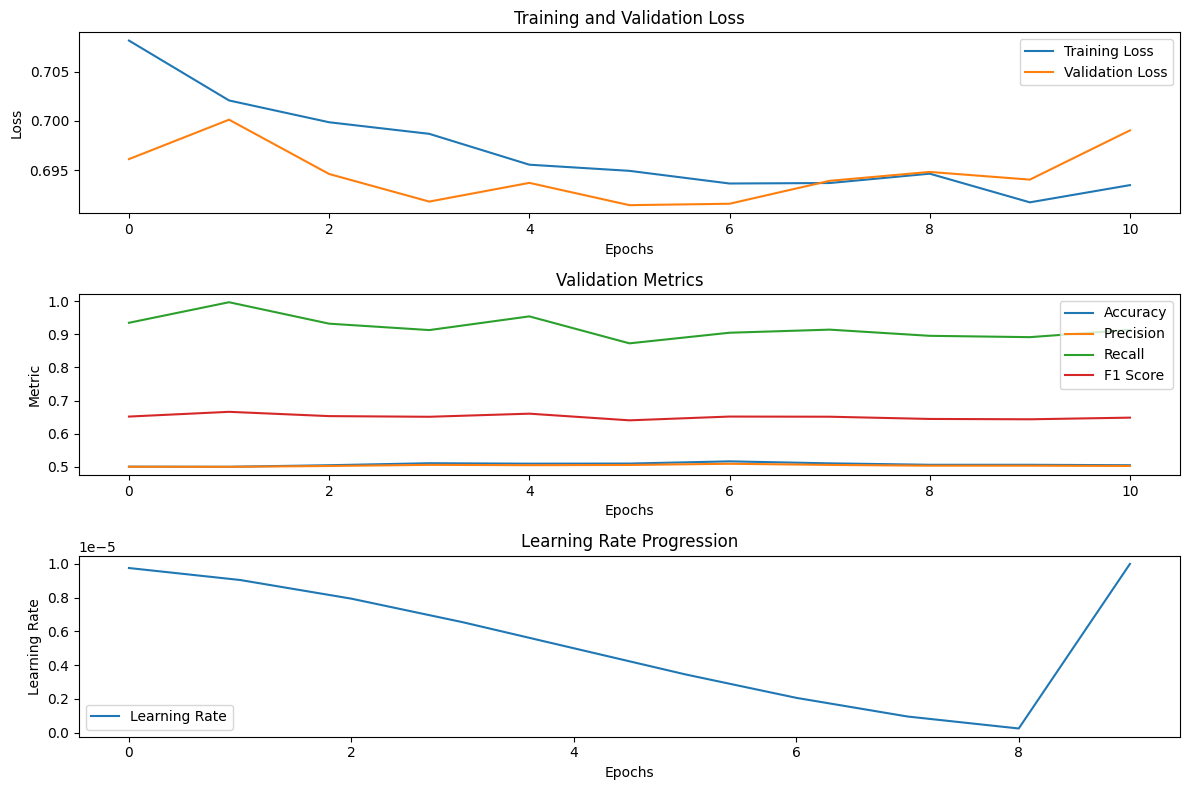

 56%|█████▋    | 27/48 [2:45:14<2:33:25, 438.34s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7064 at epoch 1

Epoch 1/100 - Training Loss: 0.7202 - Validation Loss: 0.7064 - Accuracy: 0.5023 - Precision: 0.5686 - Recall: 0.0193 - F1 Score: 0.0374 - Time: 29.81 - Lr: 9.76e-06
New best model with Loss: 0.7049 at epoch 2

Epoch 2/100 - Training Loss: 0.7133 - Validation Loss: 0.7049 - Accuracy: 0.5043 - Precision: 0.6275 - Recall: 0.0213 - F1 Score: 0.0413 - Time: 29.78 - Lr: 9.05e-06
Validation loss did not improv

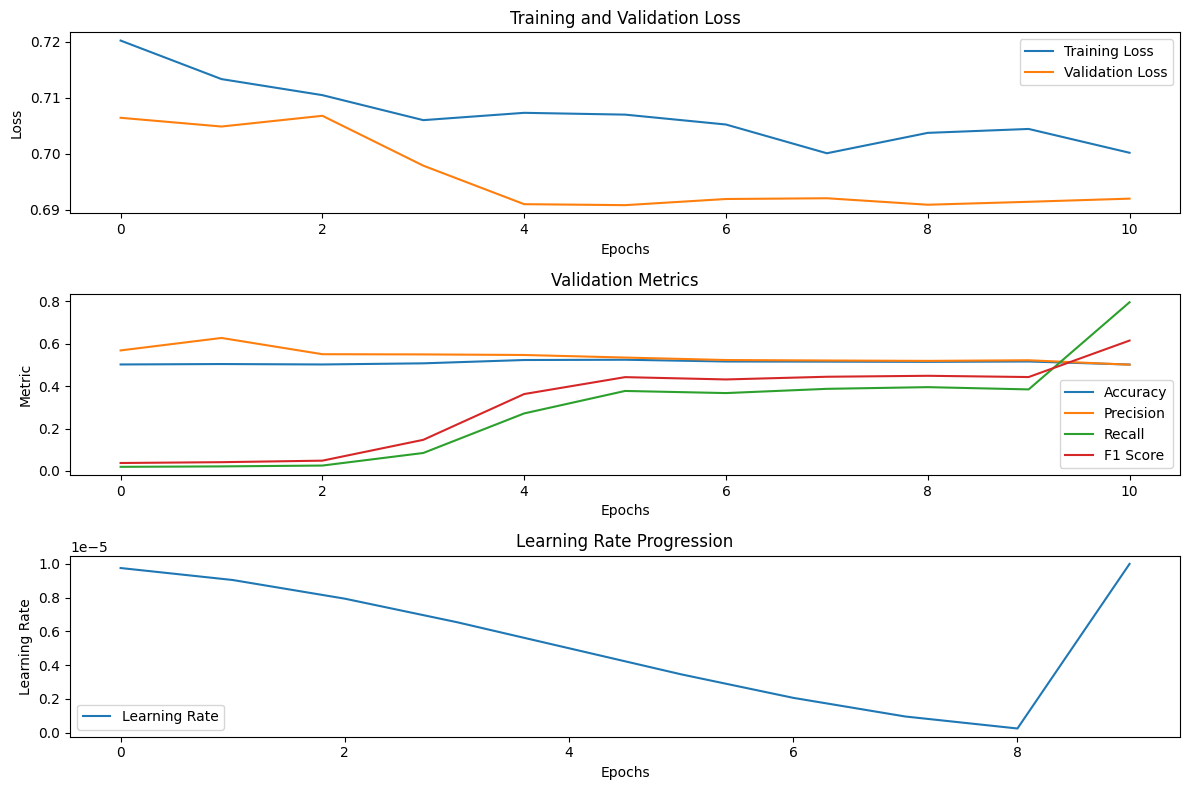

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...


 58%|█████▊    | 28/48 [2:50:44<2:15:14, 405.70s/it]

Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6953 at epoch 1

Epoch 1/100 - Training Loss: 0.7148 - Validation Loss: 0.6953 - Accuracy: 0.5210 - Precision: 0.5138 - Recall: 0.7833 - F1 Score: 0.6205 - Time: 32.93 - Lr: 9.76e-06
New best model with Loss: 0.6950 at epoch 2

Epoch 2/100 - Training Loss: 0.7065 - Validation Loss: 0.6950 - Accuracy: 0.5160 - Precision: 0.5101 - Recall: 0.8073 - F1 Score: 0.6252 - Time: 31.14 - Lr: 9.05e-06
Validation loss did not improve for 1 epoch(s).

Epoch 3/100 - Training Loss: 0.7017 - Validation Loss: 0.7021 - Accuracy: 0.5077 - Precision: 0.5041 - Recall: 0.9473 - F1 Score: 0.6580 - Time: 29.60 - Lr: 7.94e-06
Validation loss did not improve for 2 epoch(s).

Epoch 4/100 - Training Loss: 0.6994 - Validation Loss

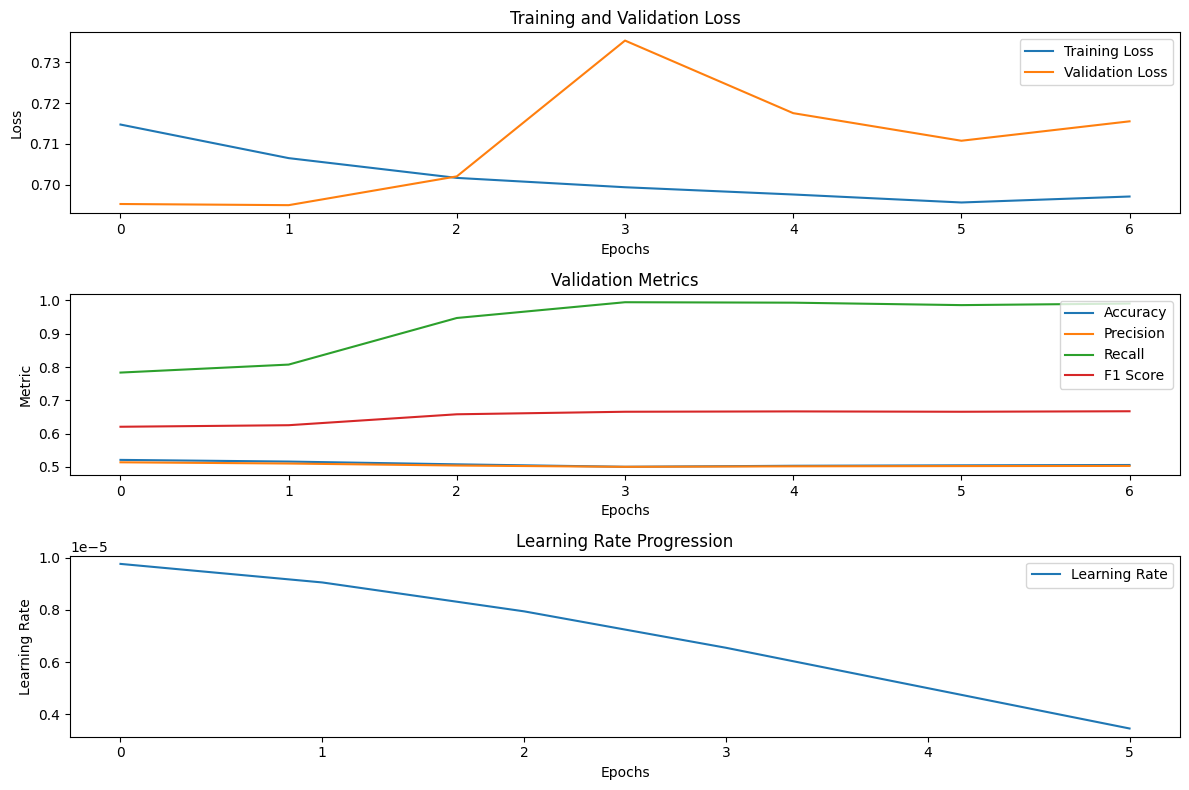

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...


 60%|██████    | 29/48 [2:54:13<1:49:50, 346.85s/it]

Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7372 at epoch 1

Epoch 1/100 - Training Loss: 0.7265 - Validation Loss: 0.7372 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 30.56 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7168 - Validation Loss: 0.7945 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 29.63 - Lr: 9.05e-06
Validation loss did not improve for 2 epoch(s).

Epoch 3/100 - Training Loss: 0.7135 - Validation Loss: 0.8116 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 32.06 - Lr: 7.94e-06
Validation loss did not improve for 3 epoch(s).

Epoch 4/100 - Training Loss: 0.7084 - Validation 

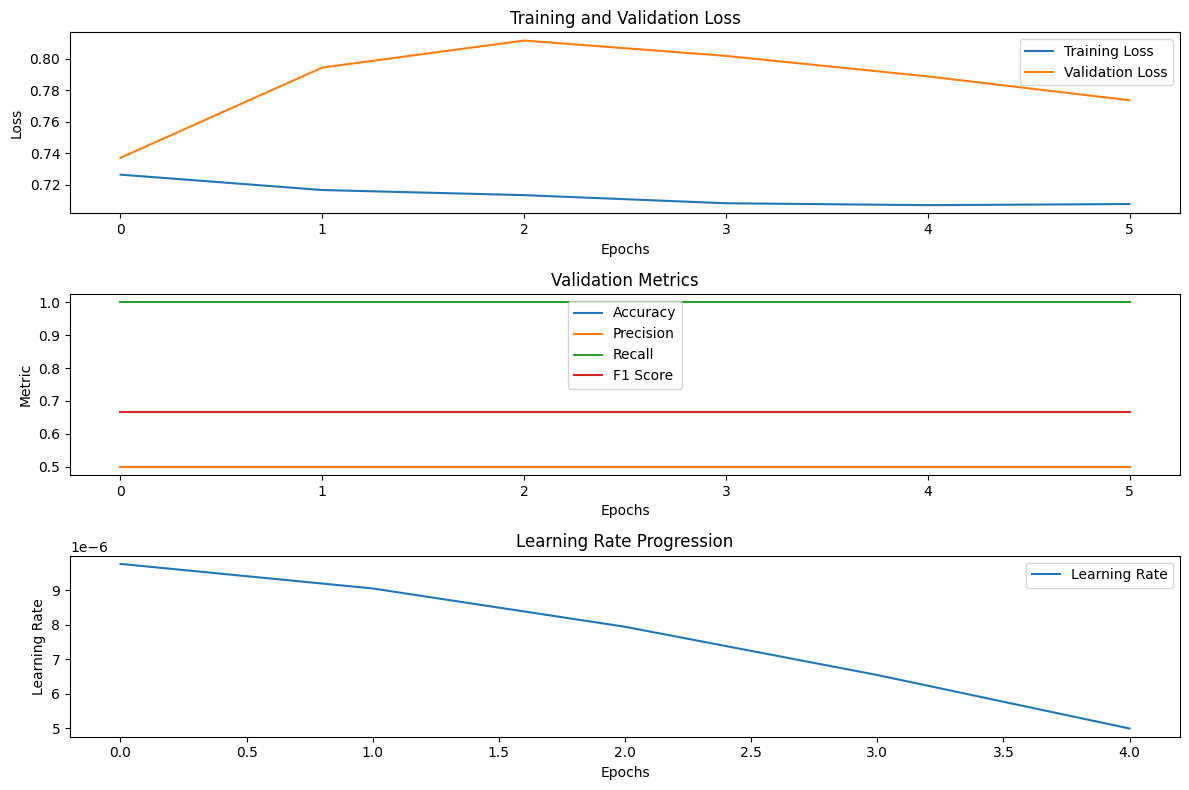

 62%|██████▎   | 30/48 [2:57:13<1:29:01, 296.73s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7000 at epoch 1

Epoch 1/100 - Training Loss: 0.7116 - Validation Loss: 0.7000 - Accuracy: 0.5073 - Precision: 0.7500 - Recall: 0.0220 - F1 Score: 0.0427 - Time: 29.63 - Lr: 9.76e-06
New best model with Loss: 0.6936 at epoch 2

Epoch 2/100 - Training Loss: 0.6995 - Validation Loss: 0.6936 - Accuracy: 0.5177 - Precision: 0.6199 - Recall: 0.0913 - F1 Score: 0.1592 - Time: 28.85 - Lr: 9.05e-06
New best model with Loss: 0.69

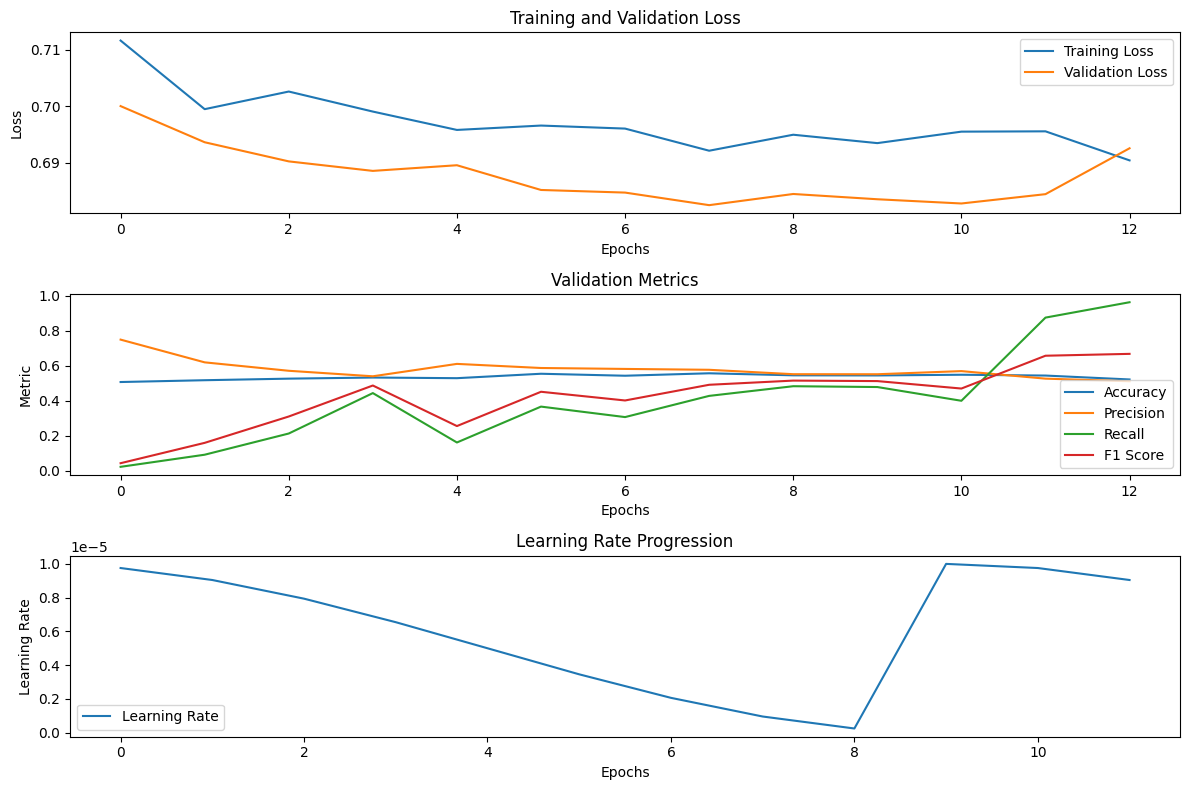

 65%|██████▍   | 31/48 [3:03:33<1:31:06, 321.54s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7403 at epoch 1

Epoch 1/100 - Training Loss: 0.7274 - Validation Loss: 0.7403 - Accuracy: 0.4990 - Precision: 0.4995 - Recall: 0.9973 - F1 Score: 0.6656 - Time: 29.97 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7144 - Validation Loss: 0.7728 - Accuracy: 0.4997 - Precision: 0.4998 - Recall: 0.9993 - F1 Score: 0.6664 - Time: 29.33 - Lr: 9.05e-06
Validation loss did not im

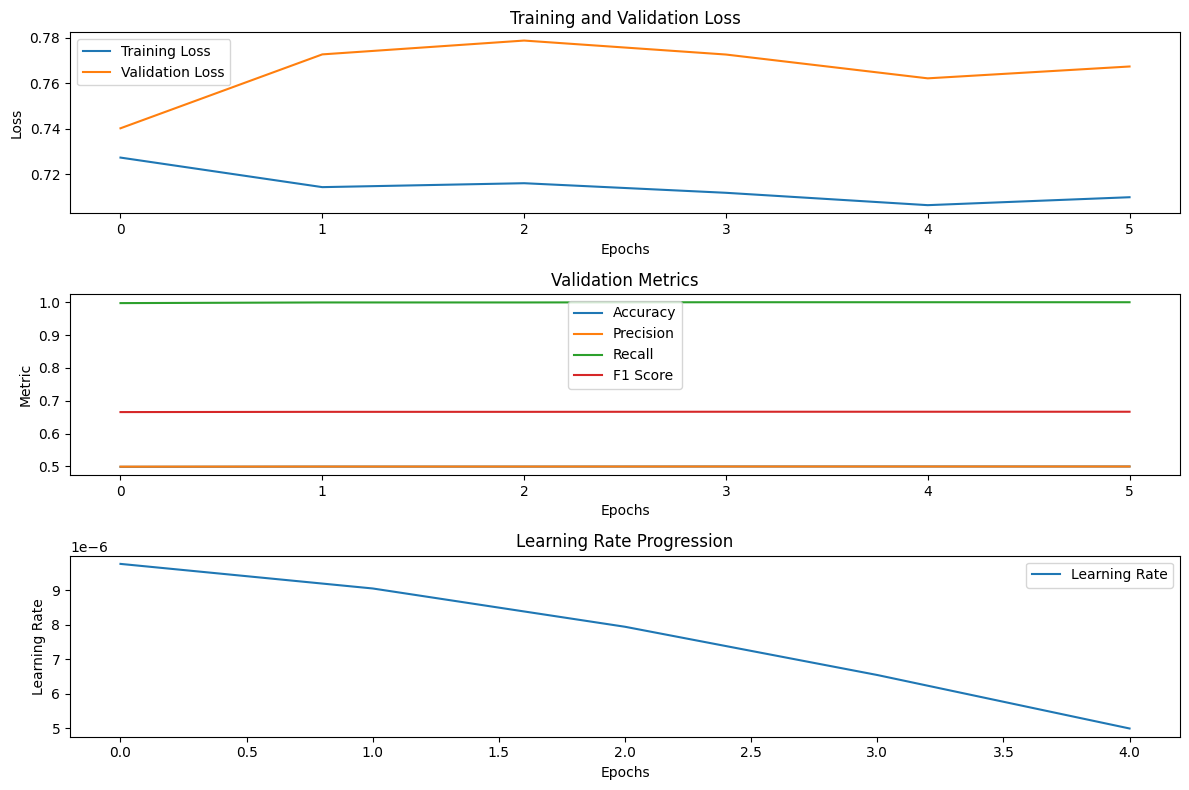

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...


 67%|██████▋   | 32/48 [3:06:29<1:14:08, 278.03s/it]

Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6931 at epoch 1

Epoch 1/100 - Training Loss: 0.7130 - Validation Loss: 0.6931 - Accuracy: 0.5233 - Precision: 0.5136 - Recall: 0.8787 - F1 Score: 0.6483 - Time: 29.90 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7072 - Validation Loss: 0.7039 - Accuracy: 0.5110 - Precision: 0.5059 - Recall: 0.9380 - F1 Score: 0.6573 - Time: 29.74 - Lr: 9.05e-06
Validation loss did not improve for 2 epoch(s).

Epoch 3/100 - Training Loss: 0.7009 - Validation Loss: 0.6939 - Accuracy: 0.5173 - Precision: 0.5112 - Recall: 0.7900 - F1 Score: 0.6207 - Time: 29.57 - Lr: 7.94e-06
Validation loss did not improve for 3 epoch(s).

Epoch 4/100 - Training Loss: 0.6990 - Validation 

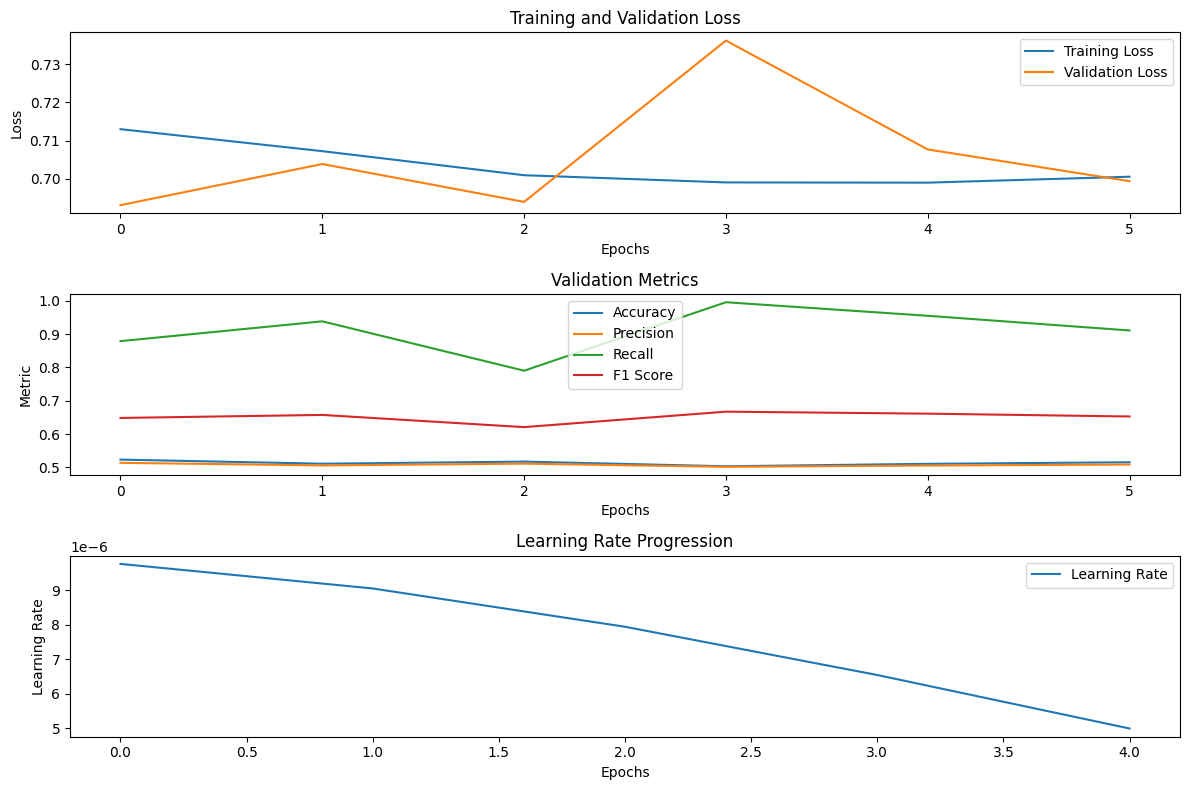

 69%|██████▉   | 33/48 [3:09:28<1:02:04, 248.28s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7326 at epoch 1

Epoch 1/100 - Training Loss: 0.7199 - Validation Loss: 0.7326 - Accuracy: 0.5020 - Precision: 0.5010 - Recall: 0.9920 - F1 Score: 0.6658 - Time: 30.29 - Lr: 9.76e-06
New best model with Loss: 0.7151 at epoch 2

Epoch 2/100 - Training Loss: 0.7177 - Validation Loss: 0.7151 - Accuracy: 0.5043 - Precision: 0.5023 - Recall: 0.9640 - F1 Score: 0.6604 - Time: 29.99 - Lr: 9.05e-06
New best model with Loss: 0.71

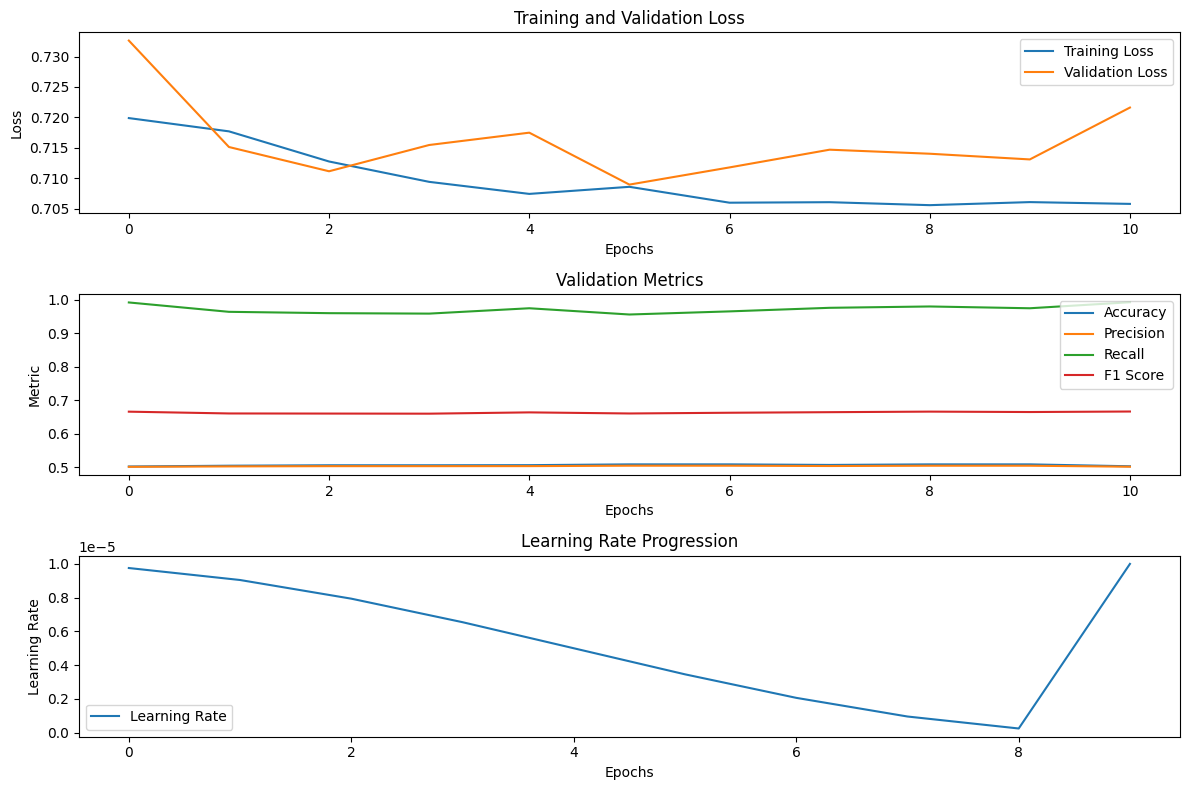

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...


 71%|███████   | 34/48 [3:15:23<1:05:22, 280.15s/it]

Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6912 at epoch 1

Epoch 1/100 - Training Loss: 0.7103 - Validation Loss: 0.6912 - Accuracy: 0.5147 - Precision: 0.5316 - Recall: 0.2467 - F1 Score: 0.3370 - Time: 43.14 - Lr: 9.76e-06
New best model with Loss: 0.6898 at epoch 2

Epoch 2/100 - Training Loss: 0.7015 - Validation Loss: 0.6898 - Accuracy: 0.5290 - Precision: 0.5341 - Recall: 0.4540 - F1 Score: 0.4908 - Time: 43.12 - Lr: 9.05e-06
Validation loss did not improve for 1 epoch(s).

Epoch 3/100 - Training Loss: 0.7025 - Validation Loss: 0.7371 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 42.92 - Lr: 7.94e-06
Validation loss did not improve for 2 epoch(s).

Epoch 4/100 - Training Loss: 0.6990 - Validation Loss

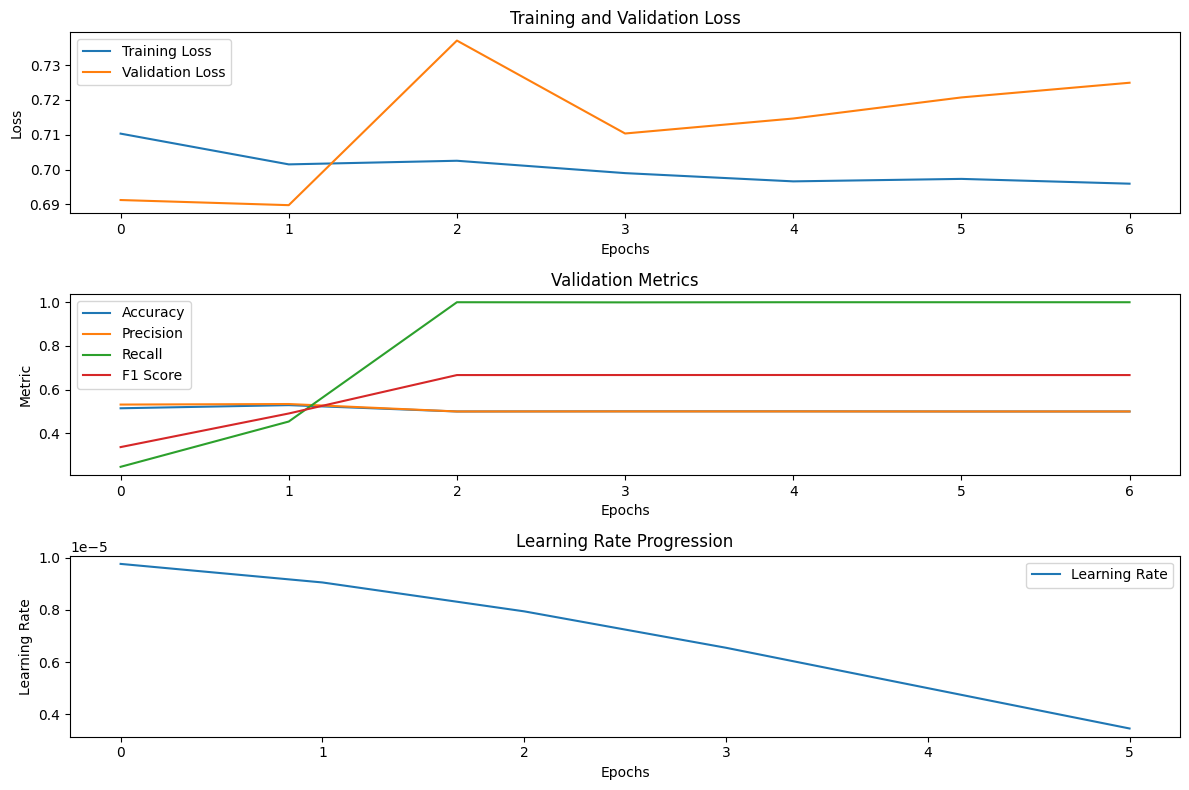

 73%|███████▎  | 35/48 [3:20:19<1:01:45, 285.06s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7308 at epoch 1

Epoch 1/100 - Training Loss: 0.7227 - Validation Loss: 0.7308 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 31.19 - Lr: 9.76e-06
New best model with Loss: 0.7117 at epoch 2

Epoch 2/100 - Training Loss: 0.7187 - Validation Loss: 0.7117 - Accuracy: 0.5003 - Precision: 0.6667 - Recall: 0.0013 - F1 Score: 0.0027 - Time: 26.99 - Lr: 9.05e-06
New best model with Loss: 0.70

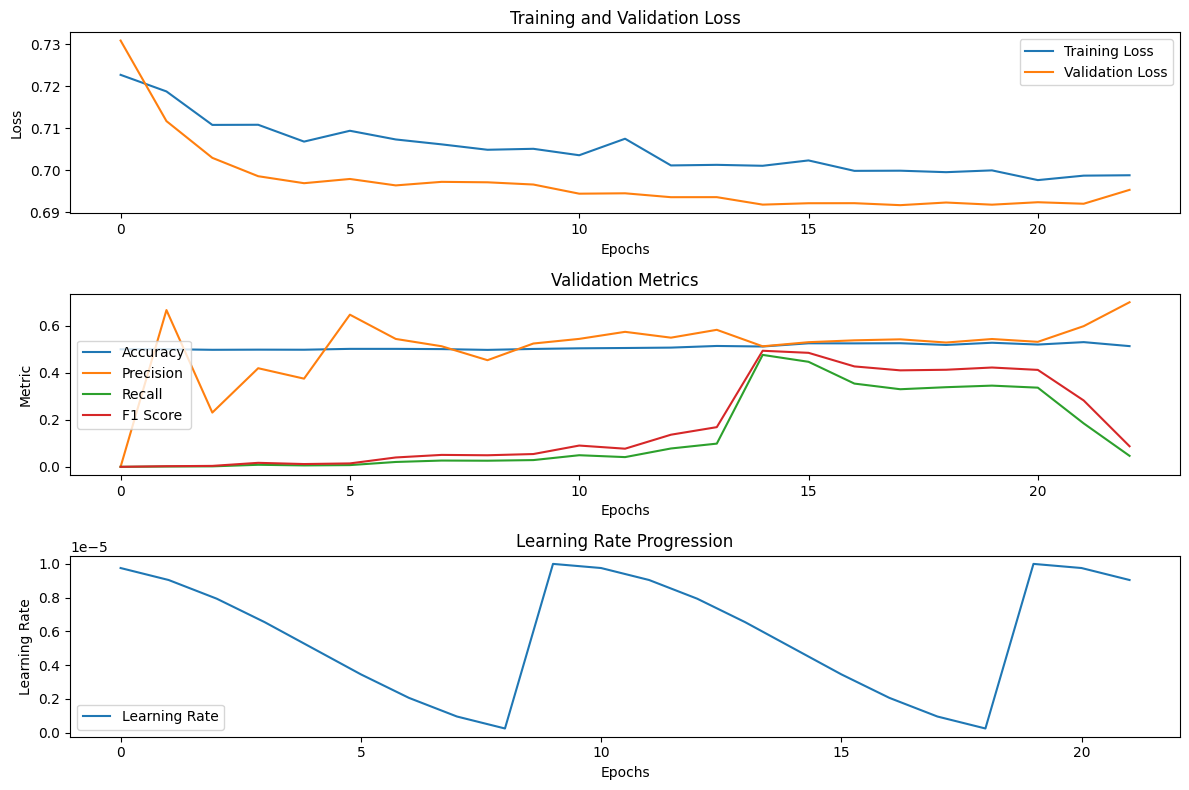

 75%|███████▌  | 36/48 [3:31:31<1:20:14, 401.23s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 256, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7029 at epoch 1

Epoch 1/100 - Training Loss: 0.7103 - Validation Loss: 0.7029 - Accuracy: 0.5067 - Precision: 0.5039 - Recall: 0.8540 - F1 Score: 0.6338 - Time: 29.96 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7027 - Validation Loss: 0.7117 - Accuracy: 0.5057 - Precision: 0.5029 - Recall: 0.9773 - F1 Score: 0.6641 - Time: 28.61 - Lr: 9.05e-06
New best model with Loss: 

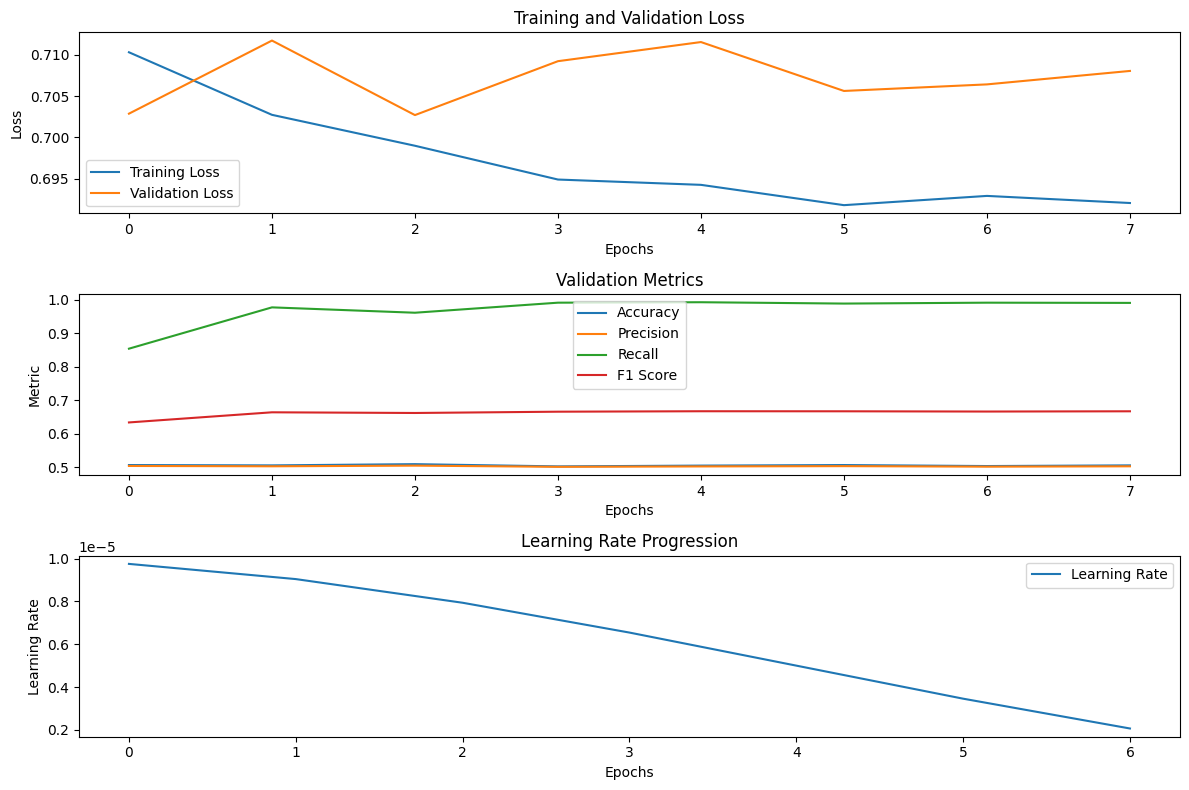

 77%|███████▋  | 37/48 [3:35:24<1:04:18, 350.81s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6938 at epoch 1

Epoch 1/100 - Training Loss: 0.7166 - Validation Loss: 0.6938 - Accuracy: 0.5240 - Precision: 0.5157 - Recall: 0.7873 - F1 Score: 0.6232 - Time: 29.89 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7124 - Validation Loss: 0.6987 - Accuracy: 0.5087 - Precision: 0.5050 - Recall: 0.8687 - F1 Score: 0.6387 - Time: 28.83 - Lr: 9.05e-06
New best model with Loss: 

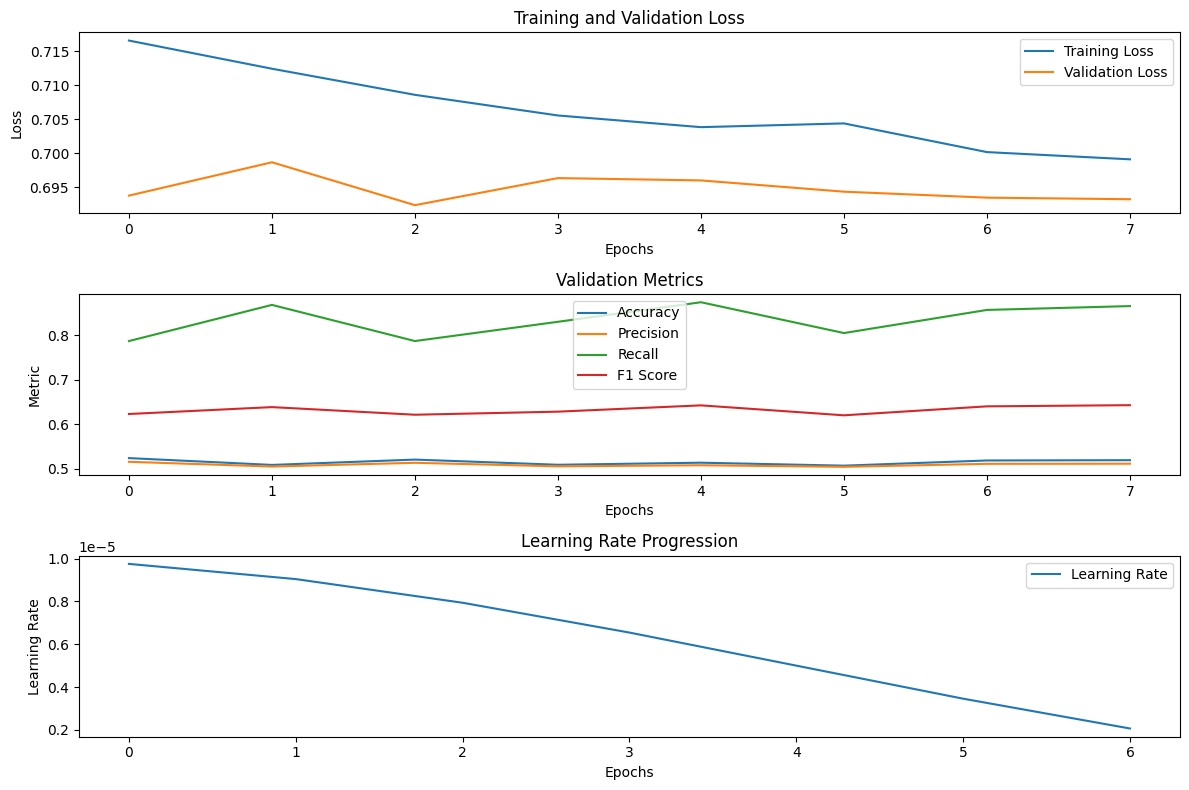

 79%|███████▉  | 38/48 [3:39:18<52:35, 315.57s/it]  

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6946 at epoch 1

Epoch 1/100 - Training Loss: 0.7032 - Validation Loss: 0.6946 - Accuracy: 0.5113 - Precision: 0.5061 - Recall: 0.9427 - F1 Score: 0.6586 - Time: 30.08 - Lr: 9.76e-06
New best model with Loss: 0.6870 at epoch 2

Epoch 2/100 - Training Loss: 0.7015 - Validation Loss: 0.6870 - Accuracy: 0.5340 - Precision: 0.5208 - Recall: 0.8520 - F1 Score: 0.6464 - Time: 29.55 - Lr: 9.05e-06
Validation loss did not improv

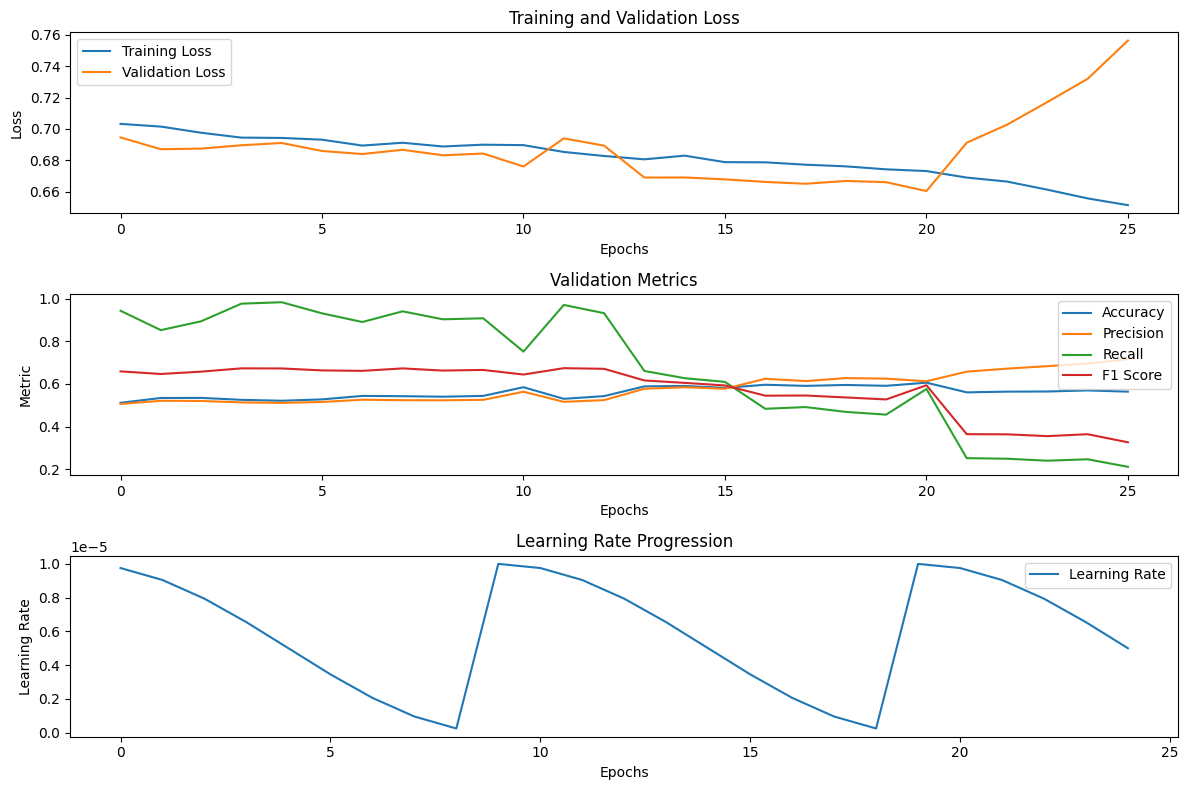

 81%|████████▏ | 39/48 [3:51:45<1:06:44, 444.94s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7176 at epoch 1

Epoch 1/100 - Training Loss: 0.7264 - Validation Loss: 0.7176 - Accuracy: 0.4970 - Precision: 0.4985 - Recall: 0.9820 - F1 Score: 0.6613 - Time: 28.70 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7159 - Validation Loss: 0.7358 - Accuracy: 0.4993 - Precision: 0.4997 - Recall: 0.9913 - F1 Score: 0.6644 - Time: 28.71 - Lr: 9.05e-06
Validation loss did not im

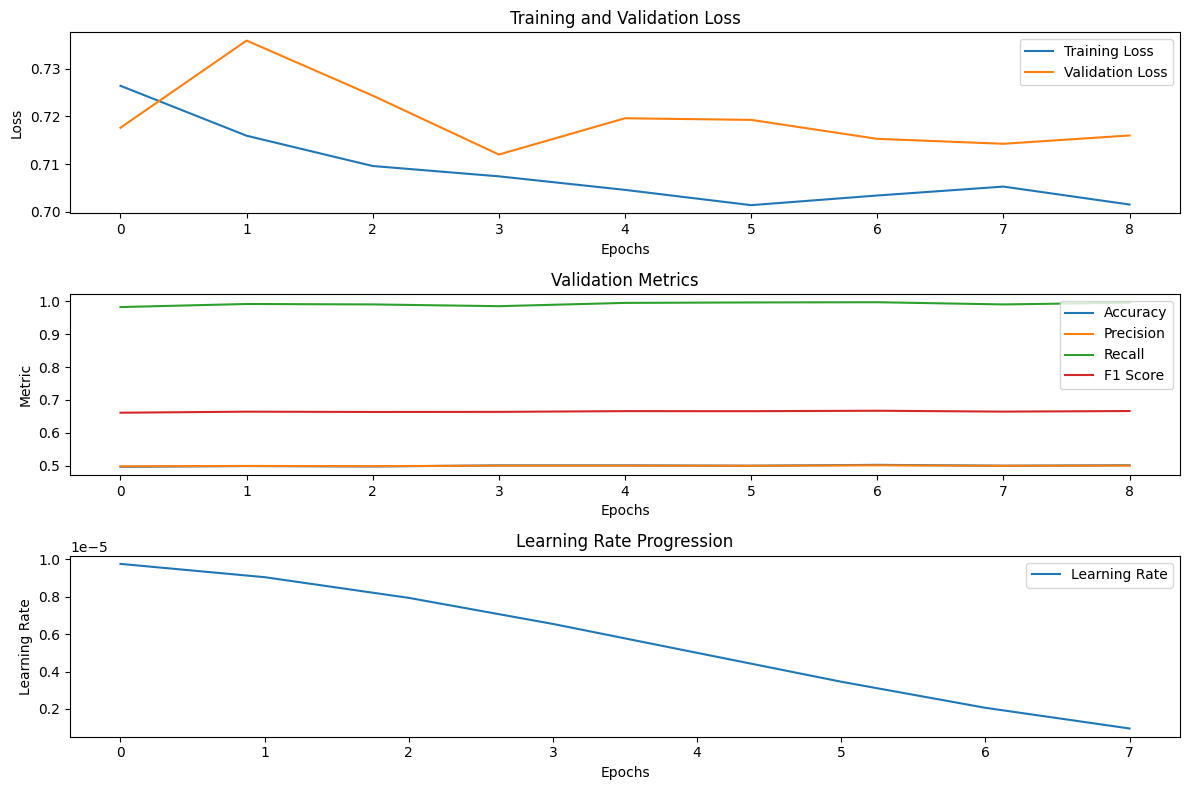

 83%|████████▎ | 40/48 [3:55:58<51:39, 387.40s/it]  

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 2, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7265 at epoch 1

Epoch 1/100 - Training Loss: 0.7120 - Validation Loss: 0.7265 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.9987 - F1 Score: 0.6664 - Time: 24.50 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7058 - Validation Loss: 0.7357 - Accuracy: 0.4997 - Precision: 0.4998 - Recall: 0.9987 - F1 Score: 0.6662 - Time: 23.90 - Lr: 9.05e-06
New best model with Loss: 

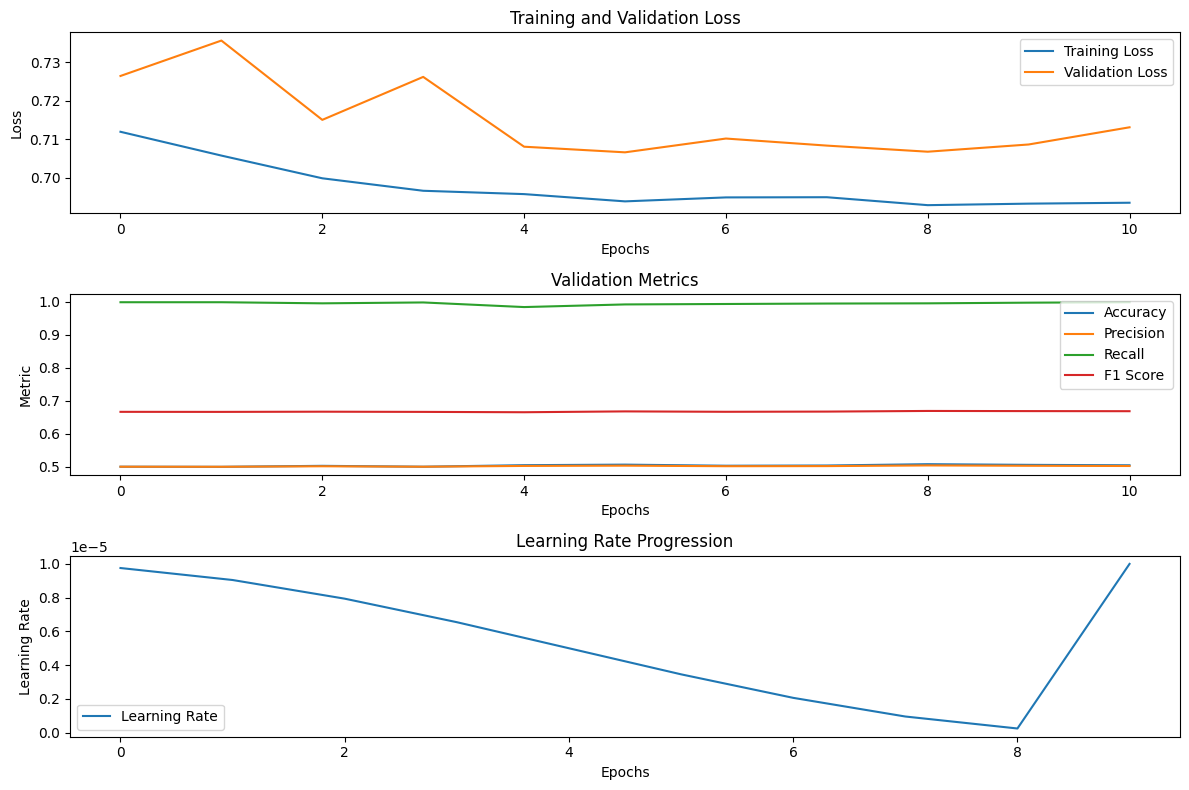

 85%|████████▌ | 41/48 [4:00:23<40:55, 350.75s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7213 at epoch 1

Epoch 1/100 - Training Loss: 0.7251 - Validation Loss: 0.7213 - Accuracy: 0.5037 - Precision: 0.5019 - Recall: 0.9440 - F1 Score: 0.6554 - Time: 24.41 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7152 - Validation Loss: 0.7541 - Accuracy: 0.5003 - Precision: 0.5002 - Recall: 0.9947 - F1 Score: 0.6656 - Time: 23.90 - Lr: 9.05e-06
Validation loss did not im

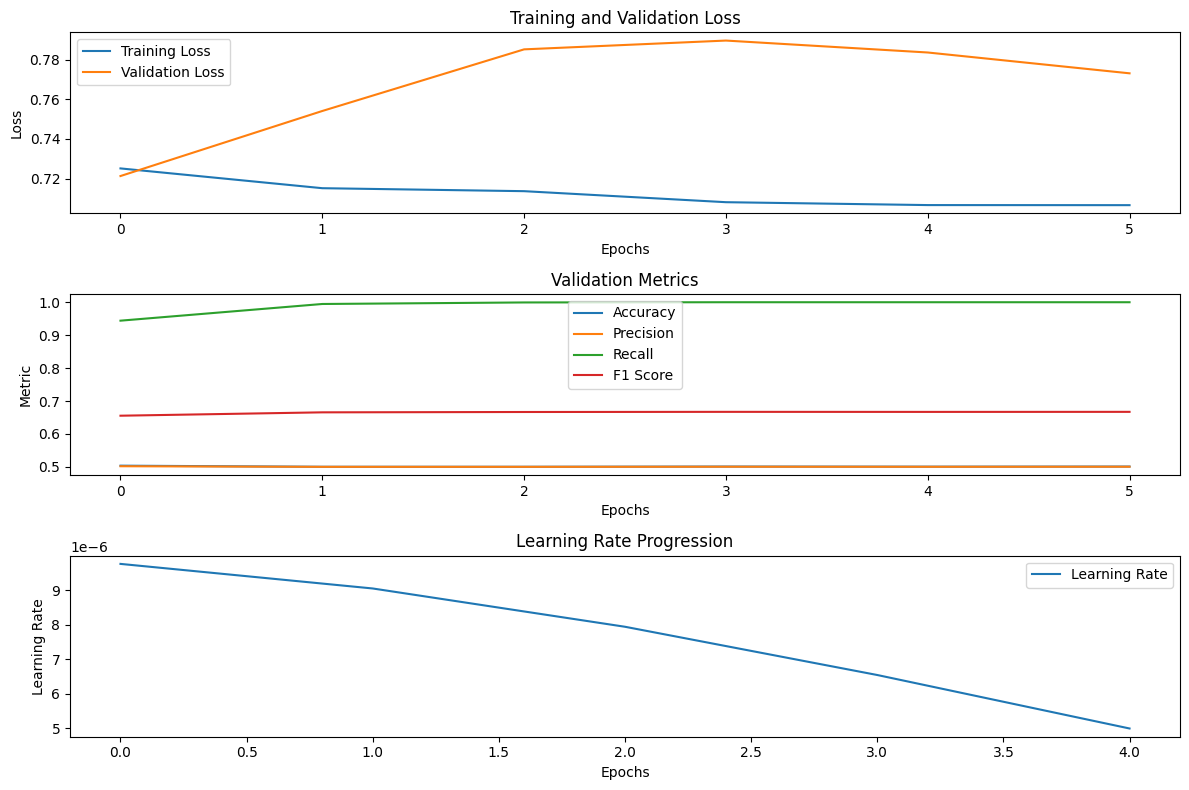

 88%|████████▊ | 42/48 [4:02:48<28:54, 289.05s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6924 at epoch 1

Epoch 1/100 - Training Loss: 0.7108 - Validation Loss: 0.6924 - Accuracy: 0.5267 - Precision: 0.5377 - Recall: 0.3800 - F1 Score: 0.4453 - Time: 24.11 - Lr: 9.76e-06
New best model with Loss: 0.6903 at epoch 2

Epoch 2/100 - Training Loss: 0.7027 - Validation Loss: 0.6903 - Accuracy: 0.5227 - Precision: 0.5212 - Recall: 0.5560 - F1 Score: 0.5381 - Time: 24.10 - Lr: 9.05e-06
New best model with Loss: 0.68

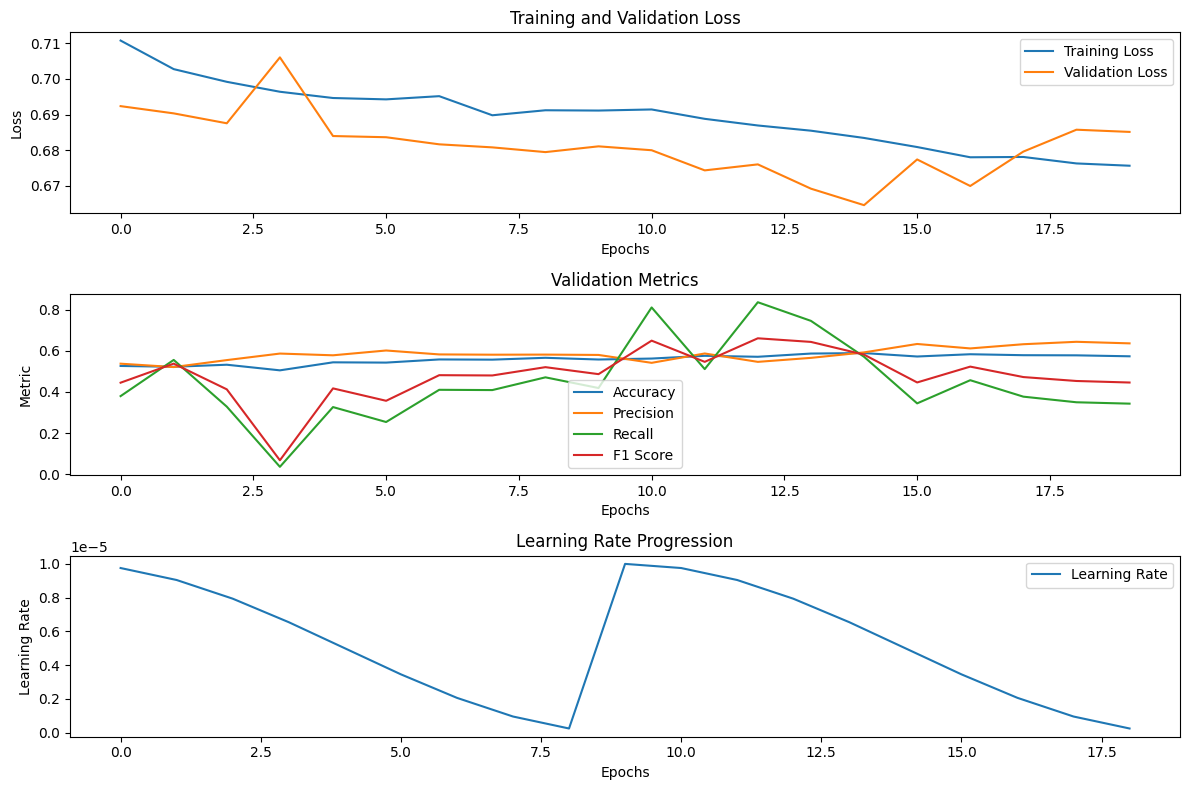

 90%|████████▉ | 43/48 [4:10:50<28:55, 347.01s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7253 at epoch 1

Epoch 1/100 - Training Loss: 0.7173 - Validation Loss: 0.7253 - Accuracy: 0.4997 - Precision: 0.4998 - Recall: 0.9993 - F1 Score: 0.6664 - Time: 24.25 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7123 - Validation Loss: 0.7485 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 24.85 - Lr: 9.05e-06
Validation loss did not im

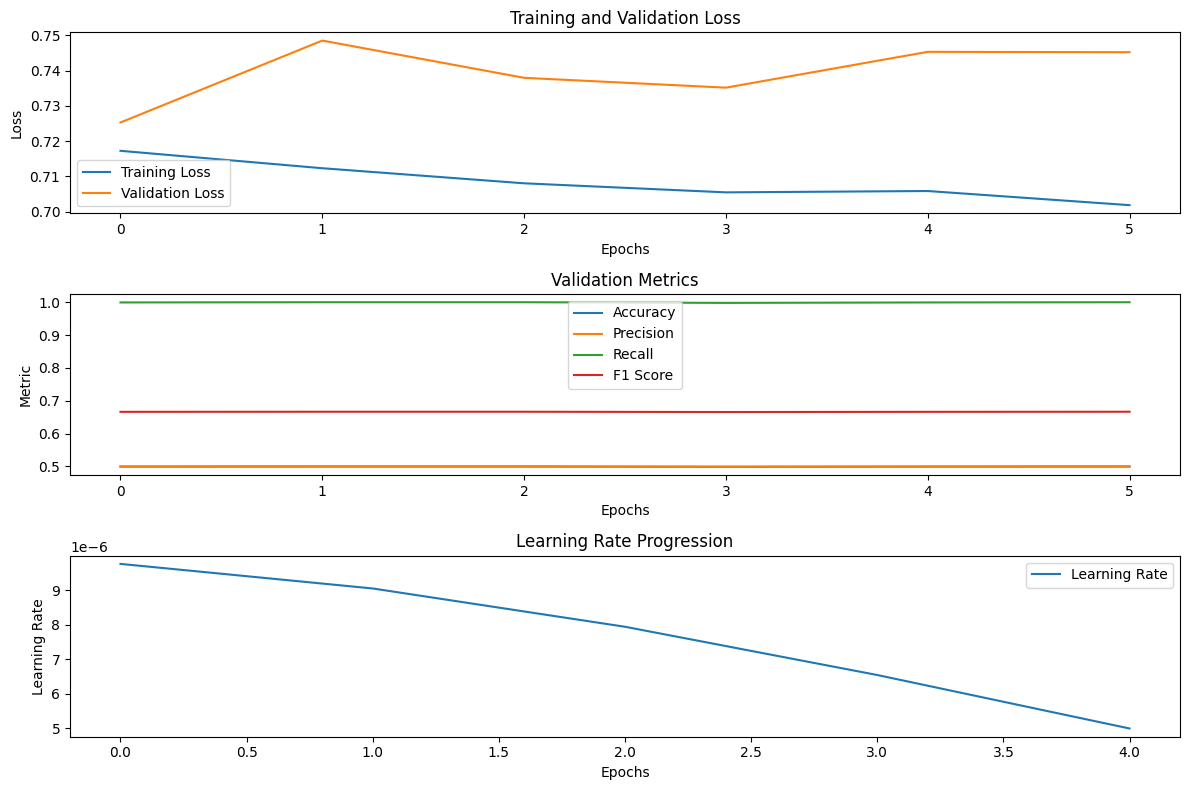

 92%|█████████▏| 44/48 [4:13:17<19:07, 286.80s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 4, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7107 at epoch 1

Epoch 1/100 - Training Loss: 0.7116 - Validation Loss: 0.7107 - Accuracy: 0.4820 - Precision: 0.4891 - Recall: 0.8107 - F1 Score: 0.6101 - Time: 25.13 - Lr: 9.76e-06
New best model with Loss: 0.7014 at epoch 2

Epoch 2/100 - Training Loss: 0.7011 - Validation Loss: 0.7014 - Accuracy: 0.4907 - Precision: 0.4930 - Recall: 0.6607 - F1 Score: 0.5647 - Time: 24.37 - Lr: 9.05e-06
New best model with Loss: 0.69

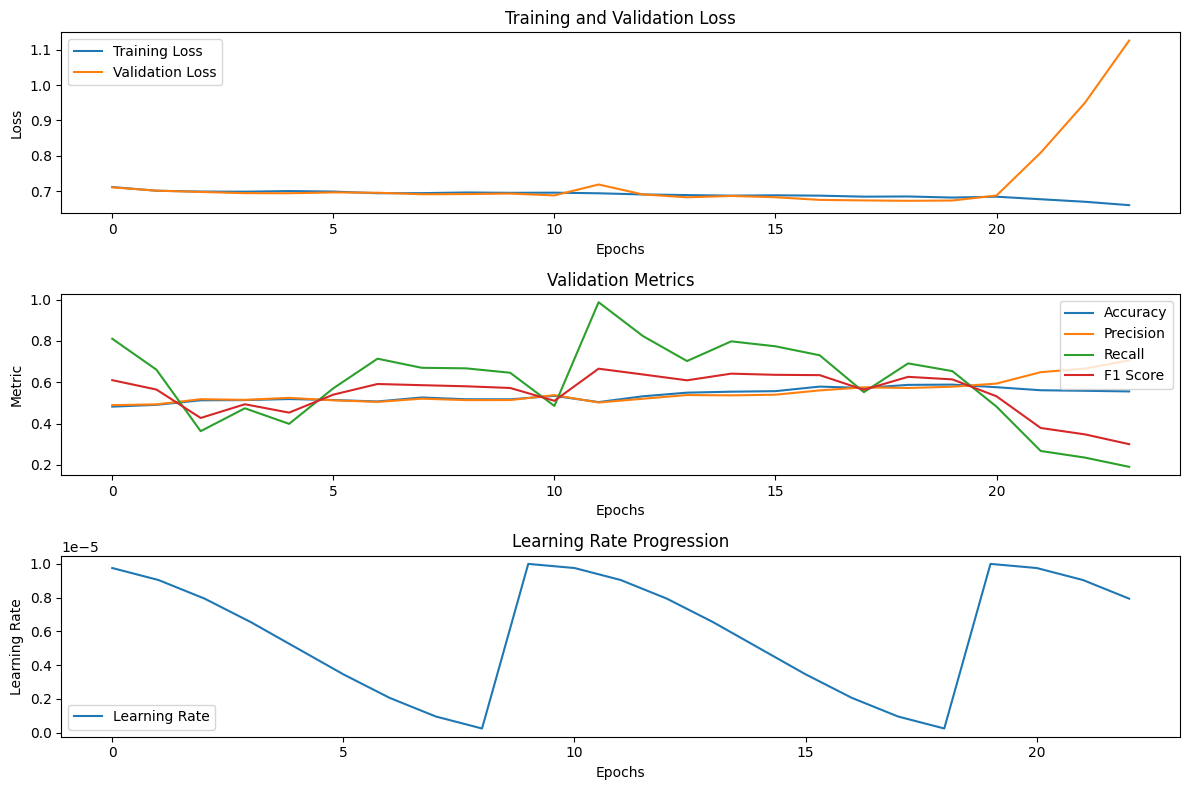

 94%|█████████▍| 45/48 [4:23:05<18:51, 377.13s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6919 at epoch 1

Epoch 1/100 - Training Loss: 0.7218 - Validation Loss: 0.6919 - Accuracy: 0.5307 - Precision: 0.5283 - Recall: 0.5733 - F1 Score: 0.5499 - Time: 24.70 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7123 - Validation Loss: 0.6952 - Accuracy: 0.5117 - Precision: 0.5093 - Recall: 0.6380 - F1 Score: 0.5664 - Time: 24.61 - Lr: 9.05e-06
Validation loss did not im

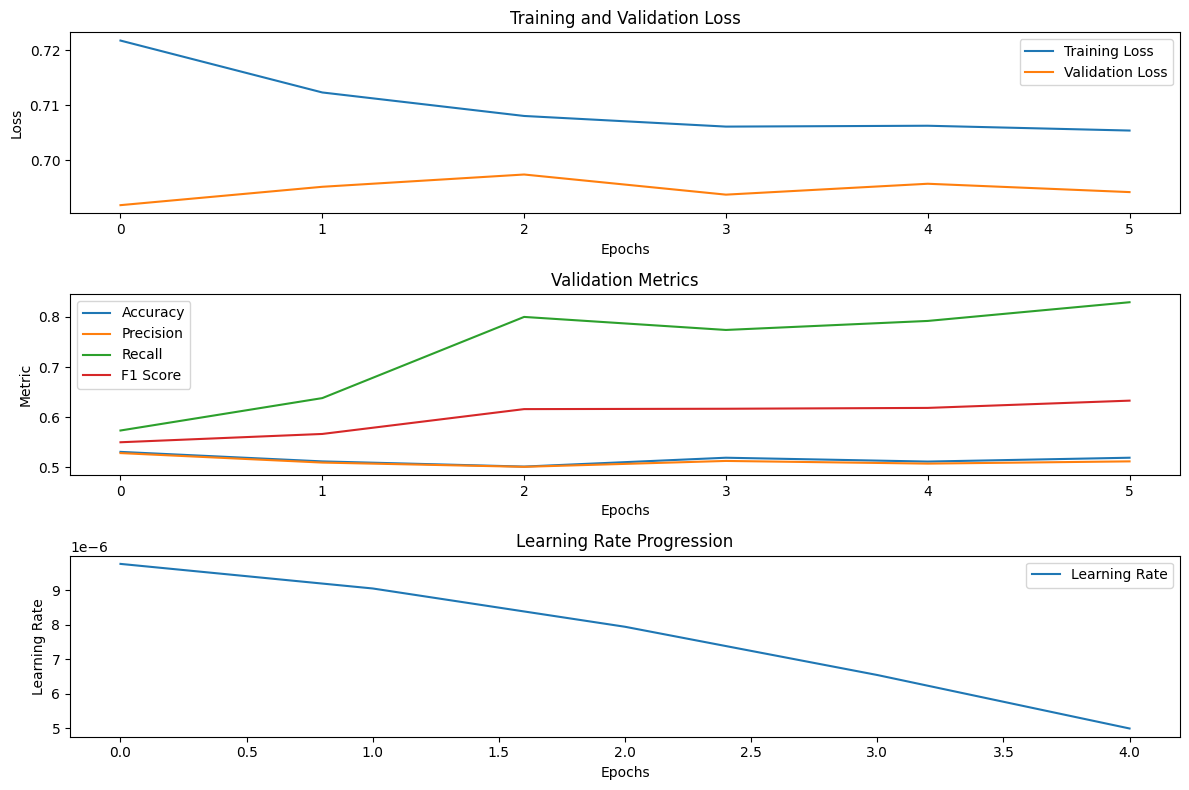

 96%|█████████▌| 46/48 [4:25:33<10:16, 308.39s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.3, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.6943 at epoch 1

Epoch 1/100 - Training Loss: 0.7073 - Validation Loss: 0.6943 - Accuracy: 0.5127 - Precision: 0.5905 - Recall: 0.0827 - F1 Score: 0.1450 - Time: 24.92 - Lr: 9.76e-06
New best model with Loss: 0.6913 at epoch 2

Epoch 2/100 - Training Loss: 0.7030 - Validation Loss: 0.6913 - Accuracy: 0.5233 - Precision: 0.5232 - Recall: 0.5267 - F1 Score: 0.5249 - Time: 24.53 - Lr: 9.05e-06
New best model with Loss: 0.69

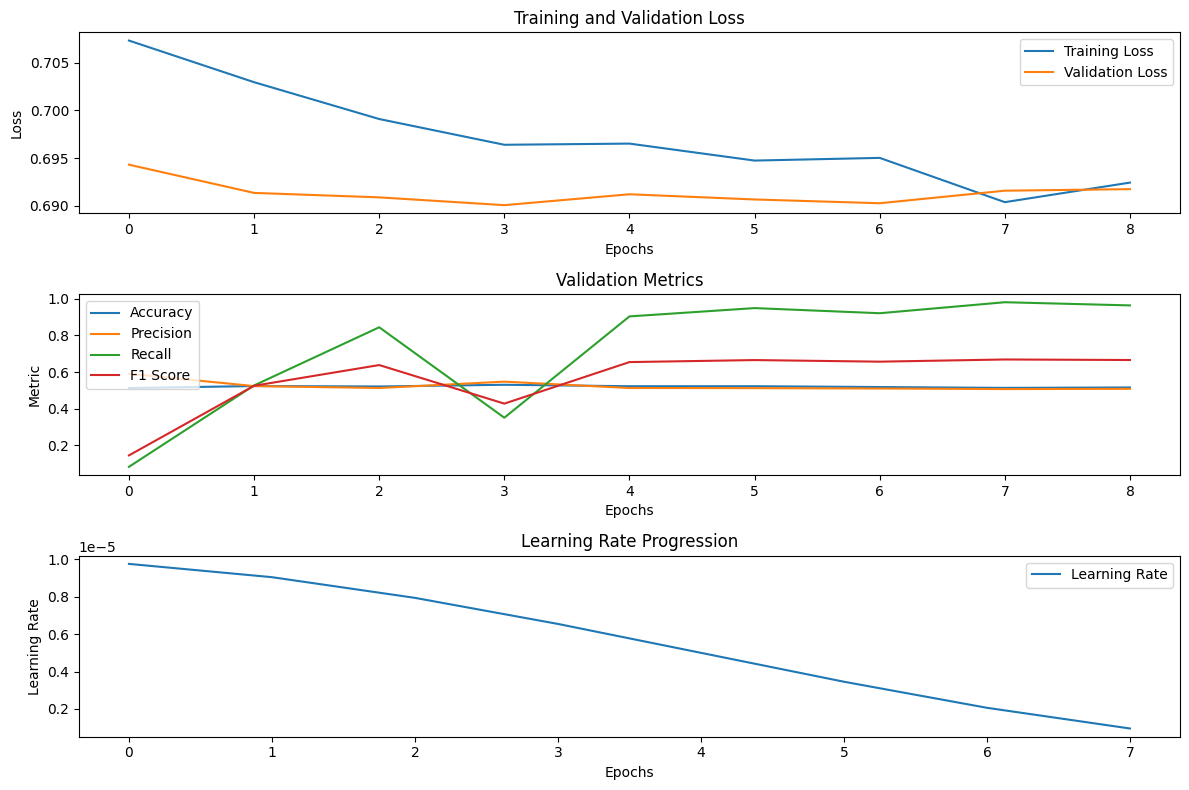

 98%|█████████▊| 47/48 [4:29:16<04:42, 282.94s/it]

Completed configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
Resetting GPU memory...
Testing configuration: {'embedding_dim': 128, 'num_heads': 4, 'transformer_hidden_dim': 512, 'num_transformer_layers': 6, 'cnn_dropout_value': 0.5, 'transformer_dropout_value': 0.7, 'lr': 1e-05, 'weight_decay': 0.0001, 'T_0': 10, 'T_mult': 1, 'eta_min': 5e-05}
New best model with Loss: 0.7727 at epoch 1

Epoch 1/100 - Training Loss: 0.7231 - Validation Loss: 0.7727 - Accuracy: 0.4993 - Precision: 0.4997 - Recall: 0.9967 - F1 Score: 0.6656 - Time: 24.52 - Lr: 9.76e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/100 - Training Loss: 0.7184 - Validation Loss: 0.8058 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 24.25 - Lr: 9.05e-06
Validation loss did not im

 98%|█████████▊| 47/48 [4:38:34<05:55, 355.62s/it]

Resetting GPU memory...


KeyboardInterrupt: 

In [71]:
results = hyperparameter_tuning(
    vocab_size=len(vocab),
    max_len=max_len,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    param_grid=param_grid,
    training_method=training_method,
    num_epochs=100
)

In [72]:
dir_models = os.listdir("./models")

In [73]:
best_models = [path[:-3] for path in dir_models if path.endswith(".pt")]

In [74]:
best_val_loss = [float(str(best_model.split("+")[-1:]).split("=")[1][:8]) for best_model in best_models]

In [75]:
best_val_loss.sort()
best_val_loss[:100]

[0.660337,
 0.664585,
 0.665792,
 0.668462,
 0.670021,
 0.672664,
 0.675811,
 0.681725,
 0.682481,
 0.684356,
 0.686619,
 0.687482,
 0.688138,
 0.689773,
 0.689816,
 0.690059,
 0.690433,
 0.690811,
 0.691084,
 0.691453,
 0.691687,
 0.691882,
 0.692092,
 0.692399,
 0.693083,
 0.69325,
 0.69375,
 0.69376,
 0.694388,
 0.694468,
 0.695002,
 0.695236,
 0.697659,
 0.701796,
 0.702709,
 0.70666,
 0.70896,
 0.712001,
 0.720319,
 0.72129,
 0.723137,
 0.725296,
 0.729258,
 0.737214,
 0.740286,
 0.749817,
 0.752434]